<a href="https://colab.research.google.com/github/jaejunchoe/2023-Gumi-Industrial-Complex-Energy-Self-Sufficiency-Datathon/blob/main/A%EC%82%AC%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from keras.src.engine.sequential import input_layer
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet
import lightgbm as lgb
from sklearn.svm import SVR
import joblib
from sklearn.cluster import KMeans

# Model Download (Import)

In [ ]:
model_en = joblib.load('Model-EN.pkl')
model_gbr = joblib.load('Model-GBR.pkl')
model_knn = joblib.load('Model-KNN.pkl')
model_lr = joblib.load('Model-KR.pkl')
model_lgbm = joblib.load('Model-LGBM.pkl')
model_lstm = joblib.load('Model-LSTM.pkl')
model_mlp = joblib.load('Model-MLP.pkl')
model_nn = joblib.load('Model-NN.pkl')
model_rf = joblib.load('Model-RF.pkl')
model_svm = joblib.load('Model-SVM.pkl')

# Data

In [ ]:
df_cluster1 = pd.read_excel('A사_cluster1.xlsx')
df_cluster2 = pd.read_excel('A사_cluster2.xlsx')
df_cluster3 = pd.read_excel('A사_cluster3.xlsx')

df = pd.read_excel('new_data.xlsx')

KeyboardInterrupt: ignored

In [ ]:
print(len(df_cluster1))
print(len(df_cluster2))
print(len(df_cluster3))

81342
154522
103569


In [ ]:
ff = df

In [ ]:
cluster_dict = {'한전메인': 3, 'B동메인': 2, 'A동 사내식당': 3, 'A동 2층 회의실/휴게실': 0, 'A동 냉난방기 메인': 3, 'A동 냉난방기 #3번': 3, 'A동 냉난방기 #2번': 3, 'A동 냉난방기 #4,5번': 3, 'A동 냉난방기 #7번': 3, 'A동 가황 메인 (L-1)': 2, 'A동 콤프레샤/배수펌프 (L-2)': 3, 'A동 콤프레샤': 2, '크린룸 판넬 메인-2번 (L-4)': 2, '크린룸 공조기 #3번(380V)': 2, 'DI 제조설비': 0, '크린룸 판넬 메인-1번': 3, 'B동 냉난방기 #4번': 0, 'B동 냉난방기 #3번': 3, 'B동 보일러/진공펌프': 2, 'B동 확관/융착 작업실': 2, '사무동 메인': 0, '사무동 2층 전열': 3, '사무동 냉난방기 메인': 0, '사무동 3층 전열': 0, '사무동 4층 전열': 3, '사무동 5층 전열': 0, '사무동 옥상 냉난방기 메인 판넬': 0, '사무동 2층 냉난방기': 0, '사무동 5층 냉난방기': 0, '사무동 3층 냉난방기': 3, '사무동 5층 냉난방기(창가)': 0, '사무동 4층 냉난방기': 0, '센서 대기방지시설(흡착탑)': 1, '센서공정 전체 메인 (P-1)': 1, '센서공정 스패어': 1, '센서 제조실 메인 (P-2)': 1, '센서 조립실 메인 (P-3)': 2}

In [ ]:
df['cluster'] = df['계측기명'].map(cluster_dict)

In [ ]:
df = ff

In [ ]:
unique_list = df['계측기명'].unique()
df_new = df[0:0].copy()

for element in unique_list:
  separated_df = df[df['계측기명'] == element]
  separated_df = separated_df.reset_index(drop=True)

  first_nonzero_index = separated_df.index[separated_df['전력량'] != 0].min()
  last_nonzero_index = separated_df.index[separated_df['전력량'] != 0].max()

  separated_df = separated_df.iloc[first_nonzero_index: last_nonzero_index + 1]

  separated_df = separated_df.reset_index(drop=True)

  df_new = pd.concat([df_new, separated_df], ignore_index=True)

df = df_new
df = df.reset_index(drop=True)

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
print(df_cluster1.info())
print(df_cluster2.info())
print(df_cluster3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81342 entries, 0 to 81341
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   계측기명     81342 non-null  object        
 1   날짜       81342 non-null  datetime64[ns]
 2   시간       81342 non-null  int64         
 3   전력량      81342 non-null  float64       
 4   lag6     81342 non-null  float64       
 5   lag12    81342 non-null  float64       
 6   lag18    81342 non-null  float64       
 7   lag24    81342 non-null  float64       
 8   CV       81342 non-null  float64       
 9   cluster  81342 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 6.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154522 entries, 0 to 154521
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   계측기명     154522 non-null  object        
 1   날짜       15

# 전처리 확인

In [ ]:
df_cluster1 = df[df['cluster'] == 0]
df_cluster2 = df[df['cluster'] == 1]
df_cluster3 = df[df['cluster'] == 2]
df_cluster4 = df[df['cluster'] == 3]

In [ ]:
# df_cluster1 = df_cluster1.drop(['lag6', 'lag12', 'lag18', 'lag24', 'cluster'], axis=1)
# df_cluster2 = df_cluster2.drop(['lag6', 'lag12', 'lag18', 'lag24', 'cluster'], axis=1)
# df_cluster3 = df_cluster3.drop(['lag6', 'lag12', 'lag18', 'lag24', 'cluster'], axis=1)
# df_cluster4 = df_cluster4.drop(['lag6', 'lag12', 'lag18', 'lag24', 'cluster'], axis=1)

KeyError: ignored

In [ ]:
df_cluster1 = df_cluster1.reset_index(drop=True)
df_cluster2 = df_cluster2.reset_index(drop=True)
df_cluster3 = df_cluster3.reset_index(drop=True)
df_cluster4 = df_cluster4.reset_index(drop=True)

In [ ]:
print(df_cluster1.info())
print(df_cluster2.info())
print(df_cluster3.info())
print(df_cluster4.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145592 entries, 0 to 145591
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   계측기명     145592 non-null  object        
 1   날짜       145592 non-null  datetime64[ns]
 2   시간       145592 non-null  int64         
 3   전력량      145592 non-null  float64       
 4   cluster  145592 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49993 entries, 0 to 49992
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   계측기명     49993 non-null  object        
 1   날짜       49993 non-null  datetime64[ns]
 2   시간       49993 non-null  int64         
 3   전력량      49993 non-null  float64       
 4   cluster  49993 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)


In [ ]:
print(df_cluster1.isna().any())
print(df_cluster2.isna().any())
print(df_cluster3.isna().any())
print(df_cluster4.isna().any())

계측기명       False
날짜         False
시간         False
전력량        False
cluster    False
dtype: bool
계측기명       False
날짜         False
시간         False
전력량        False
cluster    False
dtype: bool
계측기명       False
날짜         False
시간         False
전력량        False
cluster    False
dtype: bool
계측기명       False
날짜         False
시간         False
전력량        False
cluster    False
dtype: bool


# 자기상관계수 및 정규화

In [ ]:
for i in range(1, 10):
    print(i, df_cluster1['전력량'].autocorr(i))

for i in range(1, 10):
    print(i, df_cluster2['전력량'].autocorr(i))

for i in range(1, 10):
    print(i, df_cluster3['전력량'].autocorr(i))

for i in range(1, 10):
    print(i, df_cluster4['전력량'].autocorr(i))

1 0.9263044137383823
2 0.8307181751740907
3 0.7378901037009629
4 0.6546036631590485
5 0.5791433502533451
6 0.5057090959478362
7 0.433207743979262
8 0.36375719900893394
9 0.29832859225897745
1 0.5833450033199804
2 0.36773602628435853
3 0.28032669257989906
4 0.23621839559024432
5 0.2095170807376972
6 0.11644787474011586
7 0.0404106544328632
8 -0.011137320681699038
9 -0.0371388122342482
1 0.9460702478868963
2 0.891544568555627
3 0.8448594593788774
4 0.8084598984606949
5 0.7749903608970523
6 0.7345059253282769
7 0.6908554324733895
8 0.6543857058634933
9 0.6348895801006463
1 0.9567685287263742
2 0.8940437479819644
3 0.8293302355324252
4 0.7686029764602453
5 0.7138584640860149
6 0.6559459530638824
7 0.5976568407278198
8 0.5444713189058741
9 0.5016860081673125


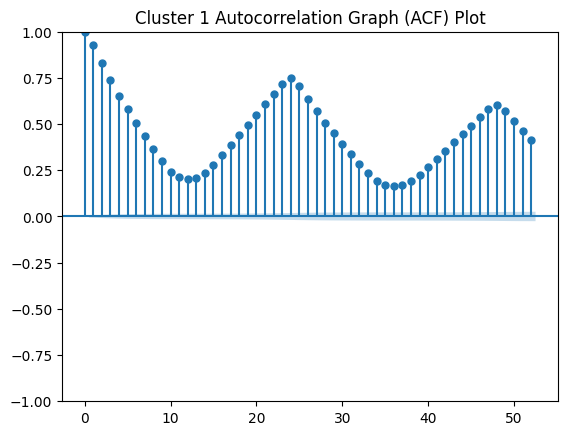

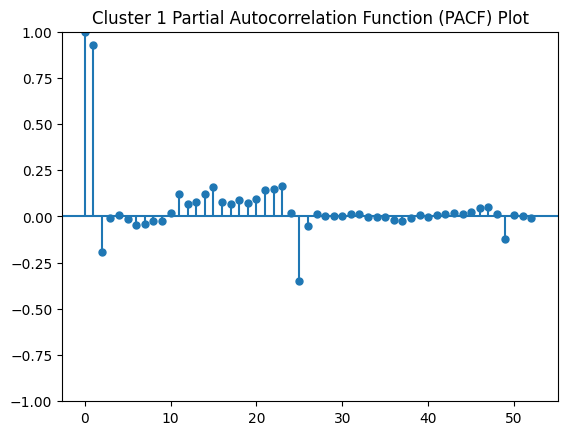

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 자기상관함수 (ACF)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_cluster1['전력량'])
plt.title('Cluster 1 Autocorrelation Graph (ACF) Plot')
plt.show()

# 편자기상관함수 (PACF)
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_cluster1['전력량'])
plt.title('Cluster 1 Partial Autocorrelation Function (PACF) Plot')
plt.show()

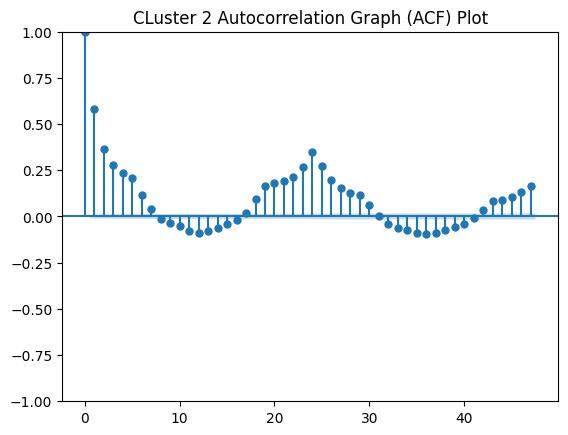

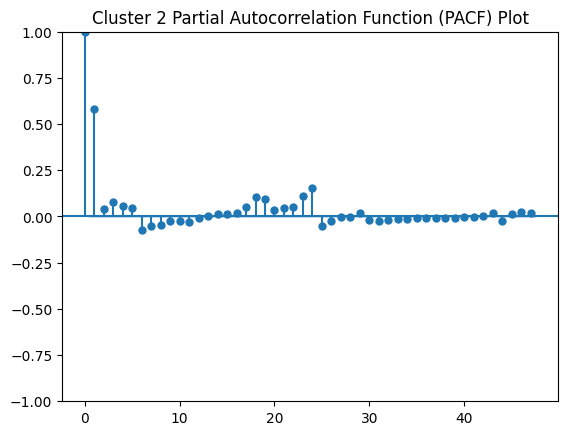

In [ ]:
# 자기상관함수 (ACF)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_cluster2['전력량'])
plt.title('CLuster 2 Autocorrelation Graph (ACF) Plot')
plt.show()

# 편자기상관함수 (PACF)
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_cluster2['전력량'])
plt.title('Cluster 2 Partial Autocorrelation Function (PACF) Plot')
plt.show()

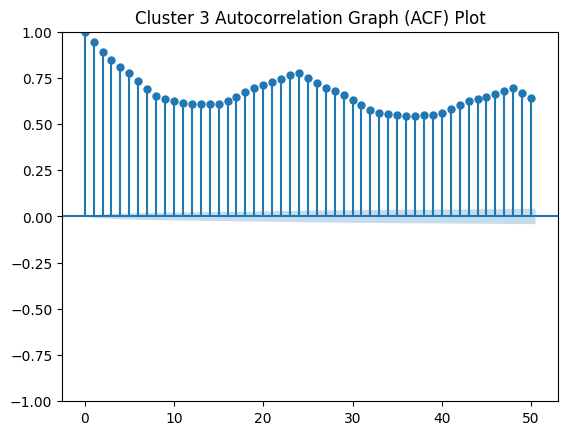

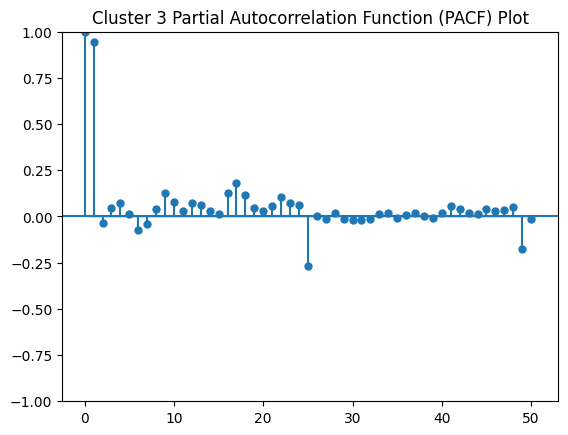

In [ ]:
# 자기상관함수 (ACF)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_cluster3['전력량'])
plt.title('Cluster 3 Autocorrelation Graph (ACF) Plot')
plt.show()

# 편자기상관함수 (PACF)
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_cluster3['전력량'])
plt.title('Cluster 3 Partial Autocorrelation Function (PACF) Plot')
plt.show()

In [ ]:
df_cluster1.loc[:,'lag1'] = df_cluster1['전력량'].shift(1)
df_cluster1.loc[:,'lag2'] = df_cluster1['전력량'].shift(2)
df_cluster1.loc[:,'lag3'] = df_cluster1['전력량'].shift(3)
df_cluster1.loc[:,'lag4'] = df_cluster1['전력량'].shift(4)

df_cluster2.loc[:,'lag1'] = df_cluster2['전력량'].shift(1)
df_cluster2.loc[:,'lag2'] = df_cluster2['전력량'].shift(2)
df_cluster2.loc[:,'lag3'] = df_cluster2['전력량'].shift(3)
df_cluster2.loc[:,'lag4'] = df_cluster2['전력량'].shift(4)

df_cluster3.loc[:,'lag1'] = df_cluster3['전력량'].shift(1)
df_cluster3.loc[:,'lag2'] = df_cluster3['전력량'].shift(2)
df_cluster3.loc[:,'lag3'] = df_cluster3['전력량'].shift(3)
df_cluster3.loc[:,'lag4'] = df_cluster3['전력량'].shift(4)

df_cluster4.loc[:,'lag1'] = df_cluster4['전력량'].shift(1)
df_cluster4.loc[:,'lag2'] = df_cluster4['전력량'].shift(2)
df_cluster4.loc[:,'lag3'] = df_cluster4['전력량'].shift(3)
df_cluster4.loc[:,'lag4'] = df_cluster4['전력량'].shift(4)

In [ ]:
print(df_cluster1.info())
print(df_cluster2.info())
print(df_cluster2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81342 entries, 0 to 81341
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   계측기명    81342 non-null  object        
 1   날짜      81342 non-null  datetime64[ns]
 2   시간      81342 non-null  int64         
 3   전력량     81342 non-null  float64       
 4   lag1    81341 non-null  float64       
 5   lag2    81340 non-null  float64       
 6   lag3    81339 non-null  float64       
 7   lag4    81338 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 5.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154522 entries, 0 to 154521
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   계측기명    154522 non-null  object        
 1   날짜      154522 non-null  datetime64[ns]
 2   시간      154522 non-null  int64         
 3   전력량     154522 non-null  f

In [ ]:
# df_cluster1 = df_cluster1[(df_cluster1['전력량'] != 0) & (df_cluster1['lag1'] != 0) &
#         (df_cluster1['lag2'] != 0) & (df_cluster1['lag3'] != 0) &
#         (df_cluster1['lag4'] != 0)]

# df_cluster2 = df_cluster2[(df_cluster2['전력량'] != 0) & (df_cluster2['lag1'] != 0) &
#         (df_cluster2['lag2'] != 0) & (df_cluster2['lag3'] != 0) &
#         (df_cluster2['lag4'] != 0)]

# df_cluster3 = df_cluster3[(df_cluster3['전력량'] != 0) & (df_cluster3['lag1'] != 0) &
#         (df_cluster3['lag2'] != 0) & (df_cluster3['lag3'] != 0) &
#         (df_cluster3['lag4'] != 0)]

In [ ]:
df_cluster1 = df_cluster1.dropna()
df_cluster2 = df_cluster2.dropna()
df_cluster3 = df_cluster3.dropna()
df_cluster4 = df_cluster4.dropna()

df_cluster1 = df_cluster1.reset_index(drop=True)
df_cluster2 = df_cluster2.reset_index(drop=True)
df_cluster3 = df_cluster3.reset_index(drop=True)
df_cluster4 = df_cluster4.reset_index(drop=True)

In [ ]:
df_cluster1 = df_cluster1.drop(['계측기명', '날짜'], axis=1)
df_cluster2 = df_cluster2.drop(['계측기명', '날짜'], axis=1)
df_cluster3 = df_cluster3.drop(['계측기명', '날짜'], axis=1)
df_cluster4 = df_cluster4.drop(['계측기명', '날짜'], axis=1)

In [ ]:
df_cluster1 = df_cluster1.drop(['cluster'], axis=1)
df_cluster2 = df_cluster2.drop(['cluster'], axis=1)
df_cluster3 = df_cluster3.drop(['cluster'], axis=1)
df_cluster4 = df_cluster4.drop(['cluster'], axis=1)

In [ ]:
print(df_cluster1.isna().any())
print(df_cluster2.isna().any())
print(df_cluster3.isna().any())
print(df_cluster4.isna().any())

시간      False
전력량     False
lag1    False
lag2    False
lag3    False
lag4    False
dtype: bool
시간      False
전력량     False
lag1    False
lag2    False
lag3    False
lag4    False
dtype: bool
시간      False
전력량     False
lag1    False
lag2    False
lag3    False
lag4    False
dtype: bool
시간      False
전력량     False
lag1    False
lag2    False
lag3    False
lag4    False
dtype: bool


In [ ]:
df_cluster1 = df_cluster1.reset_index(drop=True)
df_cluster2 = df_cluster2.reset_index(drop=True)
df_cluster3 = df_cluster3.reset_index(drop=True)
df_cluster4 = df_cluster4.reset_index(drop=True)

In [ ]:
print(df_cluster1.info())
print(df_cluster1.head())

print(df_cluster2.info())
print(df_cluster2.head())

print(df_cluster3.info())
print(df_cluster3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81338 entries, 0 to 81337
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시간      81338 non-null  int64  
 1   전력량     81338 non-null  float64
 2   lag1    81338 non-null  float64
 3   lag2    81338 non-null  float64
 4   lag3    81338 non-null  float64
 5   lag4    81338 non-null  float64
 6   계측기_ID  81338 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 4.3 MB
None
   시간     전력량    lag1    lag2   lag3   lag4  계측기_ID
0  21   9.597   9.395   8.902  7.146  1.606       1
1  22   9.835   9.597   9.395  8.902  7.146       1
2  23  10.075   9.835   9.597  9.395  8.902       1
3   0  10.365  10.075   9.835  9.597  9.395       1
4   1  10.748  10.365  10.075  9.835  9.597       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141542 entries, 0 to 141541
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   시

In [ ]:
y_cluster1 = df_cluster1['전력량']
x_cluster1 = df_cluster1.drop(['전력량'], axis=1)

y_cluster2 = df_cluster2['전력량']
x_cluster2 = df_cluster2.drop(['전력량'], axis=1)

y_cluster3 = df_cluster3['전력량']
x_cluster3 = df_cluster3.drop(['전력량'], axis=1)

y_cluster4 = df_cluster4['전력량']
x_cluster4 = df_cluster4.drop(['전력량'], axis=1)

In [ ]:
x_cluster1_train, x_cluster1_test, y_cluster1_train, y_cluster1_test = train_test_split(
    x_cluster1, y_cluster1, test_size=0.2, random_state=42)

x_cluster2_train, x_cluster2_test, y_cluster2_train, y_cluster2_test = train_test_split(
    x_cluster2, y_cluster2, test_size=0.2, random_state=42)

x_cluster3_train, x_cluster3_test, y_cluster3_train, y_cluster3_test = train_test_split(
    x_cluster3, y_cluster3, test_size=0.2, random_state=42)

x_cluster4_train, x_cluster4_test, y_cluster4_train, y_cluster4_test = train_test_split(
    x_cluster4, y_cluster4, test_size=0.2, random_state=42)

scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()

scaler1.fit(x_cluster1_train)
scaler2.fit(x_cluster2_train)
scaler3.fit(x_cluster3_train)
scaler4.fit(x_cluster4_train)

x_cluster1_train = scaler1.transform(x_cluster1_train)
x_cluster1_test = scaler1.transform(x_cluster1_test)

x_cluster2_train = scaler2.transform(x_cluster2_train)
x_cluster2_test = scaler2.transform(x_cluster2_test)

x_cluster3_train = scaler3.transform(x_cluster3_train)
x_cluster3_test = scaler3.transform(x_cluster3_test)

x_cluster4_train = scaler4.transform(x_cluster4_train)
x_cluster4_test = scaler4.transform(x_cluster4_test)

In [ ]:
x_ff1_train = x_cluster1_train
y_ff1_train = y_cluster1_train

x_ff2_train = x_cluster2_train
y_ff2_train = y_cluster2_train

x_ff3_train = x_cluster3_train
y_ff3_train = y_cluster3_train

x_ff4_train = x_cluster4_train
y_ff4_train = y_cluster4_train

# Settings for Result

In [ ]:
import matplotlib.pyplot as plt

def result(model_name):

  # MAE, R2 Score
  r2 = r2_score(y_test, model_name.predict(x_test))
  mae = mean_absolute_error(y_test, model_name.predict(x_test))

  print(f"Mean Absolute Error (MAE): {mae:.2f}")
  print(f"R-squared (R^2): {r2:.2f}")


  # 예측 데이터와 테스트 데이터의 비교
  results = pd.DataFrame(model_name.predict(x_test), columns=['Pred'])
  y_test_new = y_test.reset_index(drop=True)
  results['Test'] = y_test_new
  print(results.head(50))


  plt.figure(figsize=(12, 6))
  plt.scatter(results['Test'], results['Pred'], label='Value')
  plt.xlabel('Test')
  plt.ylabel('Pred')
  plt.legend('Test vs Pred')
  plt.grid(True)
  plt.show()

# KNN

In [ ]:
# first cluster
r2_scores = {}

for n in range(2, 50):
  knn = KNeighborsRegressor(n_neighbors=n)
  knn.fit(x_cluster1_train, y_cluster1_train)
  predict_knn1 = knn.predict(x_cluster1_test)
  r2_knn1 = r2_score(y_cluster1_test, predict_knn1)
  r2_scores[n] = r2_knn1

best_n_neighbors1 = max(r2_scores, key=r2_scores.get)
best_r2_score1 = r2_scores[best_n_neighbors1]

print(f"Лучший параметр n_neighbors cluster 1: {best_n_neighbors1}")
print(f"Лучший показатель R^2 cluster 1: {best_r2_score1}")

# second cluster
r2_scores = {}

for n in range(2, 50):
  knn = KNeighborsRegressor(n_neighbors=n)
  knn.fit(x_cluster2_train, y_cluster2_train)
  predict_knn2 = knn.predict(x_cluster2_test)
  r2_knn2 = r2_score(y_cluster2_test, predict_knn2)
  r2_scores[n] = r2_knn2

best_n_neighbors2 = max(r2_scores, key=r2_scores.get)
best_r2_score2 = r2_scores[best_n_neighbors2]

print(f"Лучший параметр n_neighbors cluster 2: {best_n_neighbors2}")
print(f"Лучший показатель R^2 cluster 2: {best_r2_score2}")

# third cluster
r2_scores = {}

for n in range(2, 50):
  knn = KNeighborsRegressor(n_neighbors=n)
  knn.fit(x_cluster3_train, y_cluster3_train)
  predict_knn3 = knn.predict(x_cluster3_test)
  r2_knn3 = r2_score(y_cluster3_test, predict_knn3)
  r2_scores[n] = r2_knn3

best_n_neighbors3 = max(r2_scores, key=r2_scores.get)
best_r2_score3 = r2_scores[best_n_neighbors3]

print(f"Лучший параметр n_neighbors cluster 3: {best_n_neighbors3}")
print(f"Лучший показатель R^2 cluster 3: {best_r2_score3}")

# fourth cluster
r2_scores = {}

for n in range(2, 50):
  knn = KNeighborsRegressor(n_neighbors=n)
  knn.fit(x_cluster4_train, y_cluster4_train)
  predict_knn4 = knn.predict(x_cluster4_test)
  r2_knn4 = r2_score(y_cluster4_test, predict_knn4)
  r2_scores[n] = r2_knn4

best_n_neighbors4 = max(r2_scores, key=r2_scores.get)
best_r2_score4 = r2_scores[best_n_neighbors3]

print(f"Лучший параметр n_neighbors cluster 3: {best_n_neighbors4}")
print(f"Лучший показатель R^2 cluster 3: {best_r2_score4}")

KeyboardInterrupt: ignored

In [ ]:
knn1 = KNeighborsRegressor(n_neighbors=5)
knn1.fit(x_cluster1_train, y_cluster1_train)

knn2 = KNeighborsRegressor(n_neighbors=9)
knn2.fit(x_cluster2_train, y_cluster2_train)

knn3 = KNeighborsRegressor(n_neighbors=13)
knn3.fit(x_cluster3_train, y_cluster3_train)

knn4 = KNeighborsRegressor(n_neighbors=10)
knn4.fit(x_cluster4_train, y_cluster4_train)

KNeighborsRegressor(n_neighbors=10)

Mean Absolute Error (MAE): 0.56
R-squared (R^2): 0.91
       Pred    Test
0    0.0000   0.000
1    0.8858   1.309
2    0.1210   0.294
3    0.9728   0.984
4   13.8076  14.998
5   13.2526  13.902
6    3.6364   3.980
7    3.2046   1.429
8    3.3068   3.838
9    0.0000   0.000
10   0.6852   0.535
11   6.8470  12.110
12   0.6252   0.545
13   0.6362   0.000
14   3.1598   3.190
15   0.6230   0.616
16   0.0000   0.000
17   0.4758   0.448
18   1.4540   1.444
19   2.0936   2.280
20   0.1698   0.000
21   2.7942   0.320
22   0.5186   0.460
23   0.0000   0.000
24   0.5920   0.690
25   0.4086   0.426
26   0.5718   0.600
27   4.7934   3.038
28   0.0000   0.000
29   1.2854   0.000
30   0.6326   0.778
31   0.6942   0.701
32  16.9204  17.540
33   0.0000   0.000
34   6.0976   7.020
35   2.3160   2.357
36   0.0000   0.191
37   0.8484   0.803
38   4.3828   4.391
39   0.0000   0.000
40   0.8596   1.036
41   3.4700   3.548
42   0.0000   0.000
43   0.0000   0.000
44   0.7954   0.755
45   0.0000   0.000
46   0

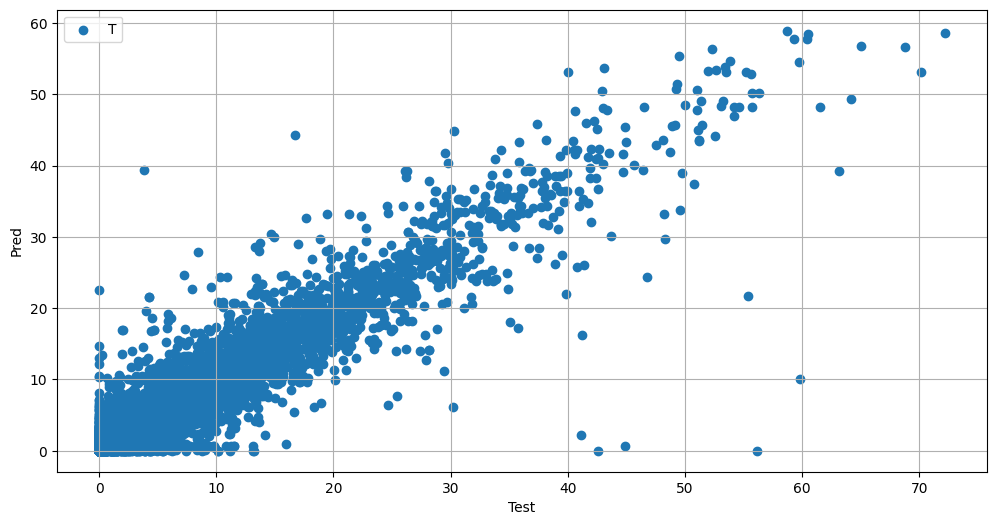

In [ ]:
# MAE, R2 Score
r2 = r2_score(y_cluster1_test, knn1.predict(x_cluster1_test))
mae = mean_absolute_error(y_cluster1_test, knn1.predict(x_cluster1_test))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(knn1.predict(x_cluster1_test), columns=['Pred'])
y_test_new = y_cluster1_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Mean Absolute Error (MAE): 0.55
R-squared (R^2): 0.54
        Pred   Test
0   0.002778  0.010
1   0.000000  0.000
2   0.000000  0.000
3   0.000000  0.000
4   0.000000  0.000
5   0.000000  0.000
6   0.000000  0.000
7   0.000000  0.000
8   0.000000  0.000
9   0.000000  0.000
10  0.000000  0.000
11  0.596778  0.604
12  0.000000  0.000
13  0.002222  0.000
14  0.000000  0.000
15  1.444444  0.005
16  0.002222  0.000
17  0.000111  0.002
18  0.009111  0.000
19  0.000000  0.000
20  0.000000  0.000
21  5.293444  2.510
22  0.002222  0.000
23  0.000000  0.000
24  0.000000  0.000
25  0.000000  0.000
26  0.000000  0.000
27  0.000000  0.000
28  0.000000  0.044
29  0.000000  0.000
30  0.000000  0.000
31  0.000000  0.000
32  0.000000  0.000
33  0.000000  0.000
34  0.000000  0.000
35  0.000000  0.000
36  0.000000  0.000
37  2.367111  5.434
38  0.000000  0.000
39  0.000000  0.000
40  0.000000  0.000
41  0.000000  0.000
42  0.000000  0.000
43  0.000000  0.000
44  0.007778  0.029
45  0.021667  0.020
46  0.

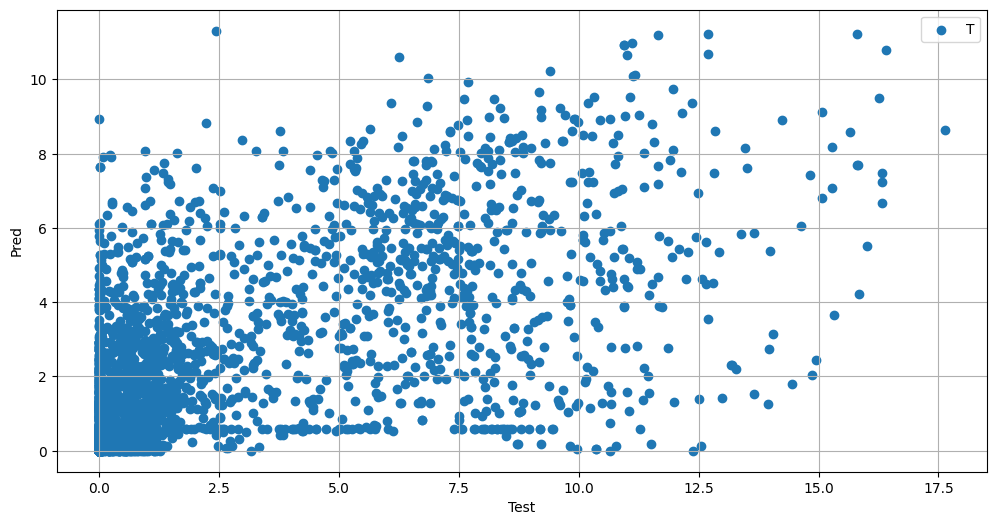

In [ ]:
# MAE, R2 Score
r2 = r2_score(y_cluster2_test, knn2.predict(x_cluster2_test))
mae = mean_absolute_error(y_cluster2_test, knn2.predict(x_cluster2_test))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(knn2.predict(x_cluster2_test), columns=['Pred'])
y_test_new = y_cluster2_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Mean Absolute Error (MAE): 0.35
R-squared (R^2): 0.93
         Pred    Test
0    6.701462   6.660
1   10.132923  11.927
2    0.000000   0.000
3    0.000000   0.000
4    5.939231   6.146
5    0.000000   0.000
6    0.957231   0.989
7    1.749538   1.836
8   11.484462  11.640
9    0.000000   0.000
10   1.418154   1.410
11   0.000000   0.000
12   0.352385   0.298
13   0.000000   0.000
14   0.103385   0.047
15   0.555308   2.222
16   0.000000   0.000
17   0.481462   0.457
18   0.000000   0.000
19   5.624385   6.448
20   6.403462   5.567
21   0.000000   0.000
22   0.000000   0.000
23   1.415231   1.396
24   5.798231   5.855
25   0.018615   0.000
26   0.000000   0.000
27   0.034154   0.000
28   6.987615   6.951
29   0.574279   0.661
30   0.405308   0.252
31   5.801154   3.620
32   0.626692   0.776
33   0.642769   0.564
34   0.000000   0.000
35   0.128692   0.130
36   1.311077   1.615
37   2.931538   1.308
38   6.361308   6.289
39   0.000000   0.000
40   0.128154   0.446
41   0.230231   0.048


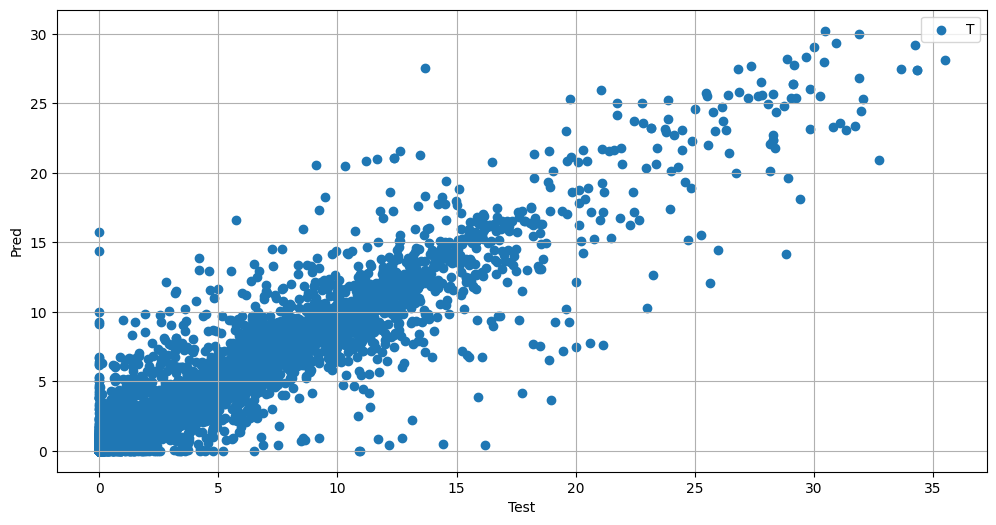

In [ ]:
# MAE, R2 Score
r2 = r2_score(y_cluster3_test, knn3.predict(x_cluster3_test))
mae = mean_absolute_error(y_cluster3_test, knn3.predict(x_cluster3_test))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(knn3.predict(x_cluster3_test), columns=['Pred'])
y_test_new = y_cluster3_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Mean Absolute Error (MAE): 1.13
R-squared (R^2): 0.96
       Pred    Test
0    0.0000   0.000
1   11.6619   0.000
2    0.0000   0.000
3    0.0000   0.000
4    3.8858   3.709
5    0.6487   0.642
6    2.5621  13.024
7    0.0140   0.000
8    3.0094   3.691
9    0.0000   0.000
10   0.0000   0.000
11   0.8111   0.811
12   0.0000   0.000
13  66.1400  69.000
14   2.0897   1.711
15   0.0000   0.000
16   0.0000   0.000
17  15.5472  17.431
18   8.2484   8.155
19   0.0000   0.000
20   9.5336  13.082
21   0.7446   0.726
22   0.1329   0.157
23  14.3920  16.176
24   0.0000   0.000
25   0.3424   0.000
26  11.4747  15.022
27   0.1980   0.000
28   0.0000   0.000
29   6.5531   6.710
30   6.0443   5.332
31   0.5603   0.570
32   0.0000   0.000
33   0.0000   0.000
34   6.1667   6.356
35   0.0000   0.000
36   6.5149   6.617
37   0.0000   0.001
38  32.9557  34.837
39   0.0000   0.000
40   1.2316   0.895
41   0.1980   0.000
42   0.0000   0.000
43   2.9373   2.707
44   0.1080   0.170
45   0.0000   5.894
46   4

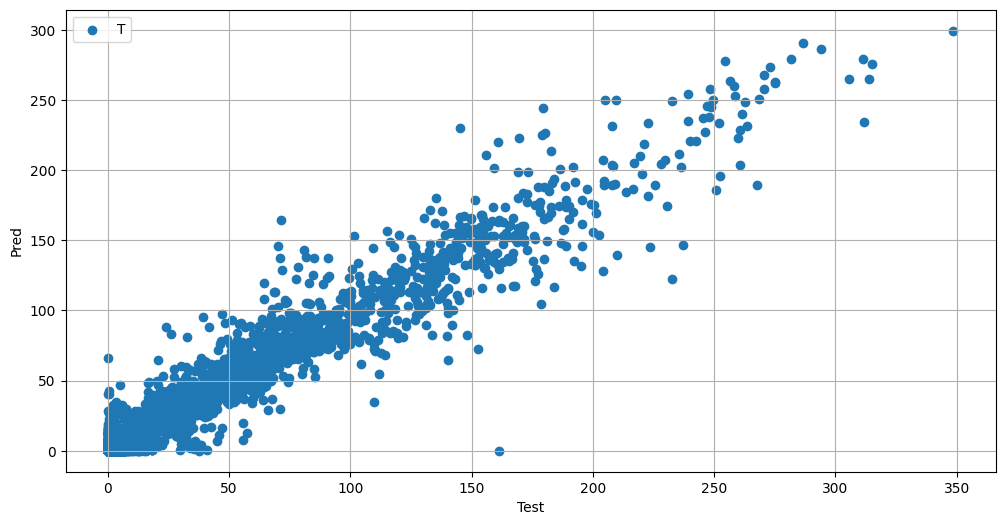

In [ ]:
# MAE, R2 Score
r2 = r2_score(y_cluster4_test, knn4.predict(x_cluster4_test))
mae = mean_absolute_error(y_cluster4_test, knn4.predict(x_cluster4_test))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(knn4.predict(x_cluster4_test), columns=['Pred'])
y_test_new = y_cluster4_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

4
센서 대기방지시설(흡착탑)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49468 (\N{HANGUL SYLLABLE SEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IP

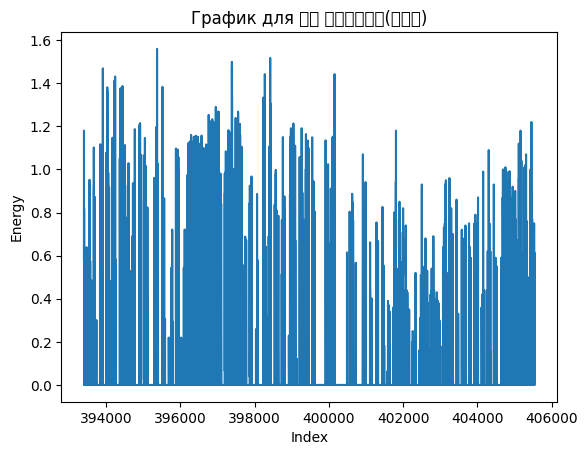

센서공정 전체 메인 (P-1)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


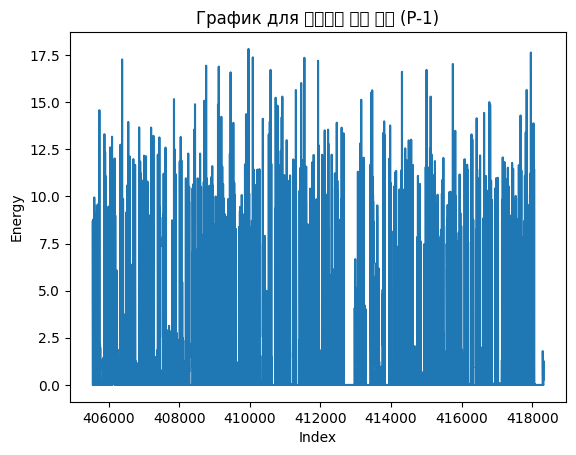

센서공정 스패어


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54056 (\N{HANGUL SYLLABLE PAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


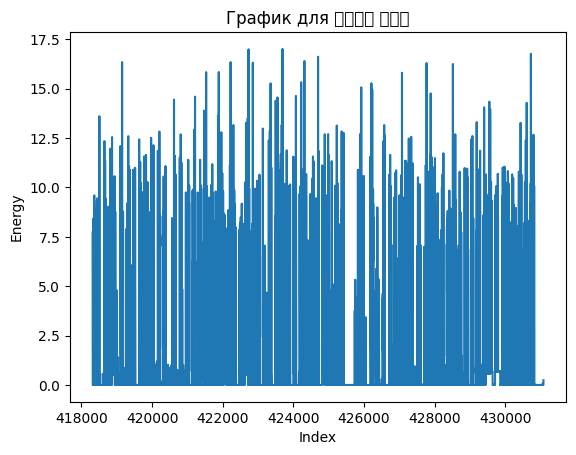

센서 제조실 메인 (P-2)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


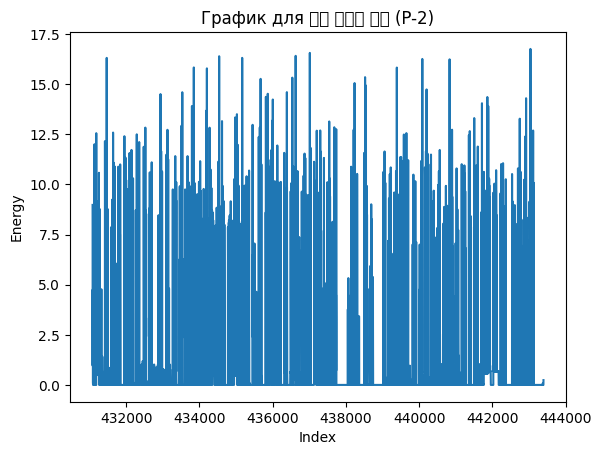

In [ ]:
# cluster4 = df[df['cluster'] == 3]
# print(cluster_0_df.head(100))

# '계측기명'열의 고유 값 추출
cluster4 = df[df['cluster'] == 1]

cluster4_list = cluster4['계측기명'].unique()
print(len(cluster4_list))

for measurement_name in cluster4_list:
    # '계측기명'열의 값 필터링
    filtered_df = cluster4[cluster4['계측기명'] == measurement_name]
    print(measurement_name)

    plt.figure()  # 그래프 생성
    plt.plot(filtered_df['전력량'])  # '전력량'열에 대한 그래프
    plt.title(f'График для {measurement_name}')  # '계측기명'열로 그래프 제목설정
    plt.xlabel('Index')  # x축 라벨을 Index
    plt.ylabel('Energy')  # y축 라벨을 Energy
    plt.show()  # 그래프 도출

['센서 대기방지시설(흡착탑)']

   cluster  count      mean
0        0  12561  0.000311
1        1    144  0.820500
2        2    160  0.315694
3        3    138  1.145957
4        4    141  0.553372
5        5     29  1.382621
6        6    149  0.165572
7        7    137  0.969423
8        8    136  0.446713
9        9    133  0.675556

['센서공정 전체 메인 (P-1)']
   cluster  count       mean
0        0  10843   0.024026
1        1    293   8.532038
2        2    478   2.182124
3        3     48  15.360062
4        4    126  12.292817
5        5    226   5.508334
6        6    999   1.154870
7        7    185  10.347027
8        8    297   7.072178
9        9    233   3.889994

['센서공정 스패어']
   cluster  count       mean
0        0  10898   0.005553
1        1    179   9.853413
2        2    236   5.103104
3        3     33  15.246030
4        4    233   2.073240
5        5    255   8.137757
6        6    309   6.639858
7        7    117  11.870556
8        8   1242   0.669877
9        9    226   3.616765

['센서 제조실 메인 (P-2)']
   cluster  count       mean
0        0  11030   0.004352
1        1    264   8.359708
2        2    213   5.156080
3        3     71  13.775155
4        4    197  10.536076
5        5    190   2.356947
6        6    307   6.709130
7        7    232   1.165172
8        8   1025   0.588978
9        9    199   3.748721

# Linear Regression

Mean Absolute Error (MAE): 0.74
R-squared (R^2): 0.87
         Pred    Test
0    0.247423   0.000
1    0.795386   1.309
2    0.507167   0.294
3    1.048472   0.984
4    4.546143  14.998
5    5.549958  13.902
6    2.261916   3.980
7    4.630533   1.429
8    3.413449   3.838
9    0.035796   0.000
10   0.811782   0.535
11   4.960538  12.110
12   1.351018   0.545
13   0.314188   0.000
14   3.351811   3.190
15   1.041952   0.616
16   0.403208   0.000
17   0.966495   0.448
18   1.770637   1.444
19   1.906725   2.280
20   0.336443   0.000
21   2.403920   0.320
22   0.830852   0.460
23   0.247423   0.000
24   0.908945   0.690
25   0.594778   0.426
26   0.607457   0.600
27   0.463375   3.038
28   0.247423   0.000
29   0.988875   0.000
30   0.601385   0.778
31   1.140202   0.701
32  16.886195  17.540
33   0.447718   0.000
34   5.942463   7.020
35   2.762236   2.357
36   0.291933   0.191
37   0.573053   0.803
38   4.284901   4.391
39   0.492228   0.000
40   1.017345   1.036
41   3.386956   3.548


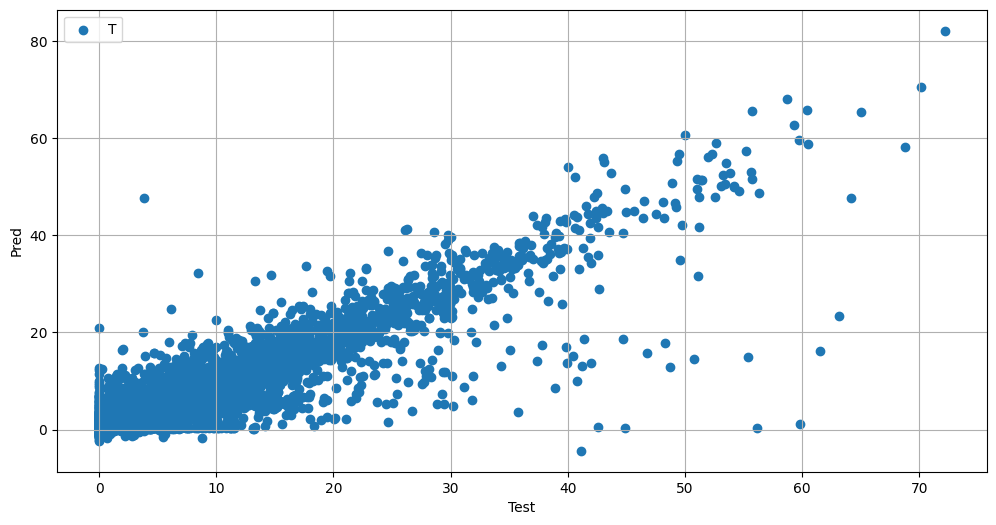

In [ ]:
lr1 = LinearRegression()
lr1.fit(x_ff1_train, y_ff1_train)
predict_lr1 = lr1.predict(x_cluster1_test)

# MAE, R2 Score
r2 = r2_score(y_cluster1_test, predict_lr1)
mae = mean_absolute_error(y_cluster1_test, predict_lr1)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_lr1, columns=['Pred'])
y_test_new = y_cluster1_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Mean Absolute Error (MAE): 1.50
R-squared (R^2): 0.94
         Pred    Test
0    0.286485   0.000
1    8.756417   0.000
2   -0.191979   0.000
3   -0.191979   0.000
4    3.356193   3.709
5    0.543013   0.642
6    2.799013  13.024
7    0.573564   0.000
8    4.285804   3.691
9    0.382178   0.000
10  -0.191979   0.000
11   1.455519   0.811
12   0.382178   0.000
13  66.551753  69.000
14   2.064946   1.711
15   0.095100   0.000
16  -0.000593   0.000
17  12.499403  17.431
18   8.532763   8.155
19   0.764950   0.000
20  12.913296  13.082
21   1.569764   0.726
22   1.179700   0.157
23  17.565219  16.176
24   0.430025   0.000
25  -0.405991   0.000
26  13.475608  15.022
27   0.238639   0.000
28   0.477871   0.000
29   6.118421   6.710
30   6.000423   5.332
31   0.703006   0.570
32   0.190793   0.000
33   0.621410   0.000
34   8.224210   6.356
35  -0.191979   0.000
36   4.217535   6.617
37   0.354600   0.001
38  31.880113  34.837
39   0.477871   0.000
40   1.609202   0.895
41   0.238639   0.000


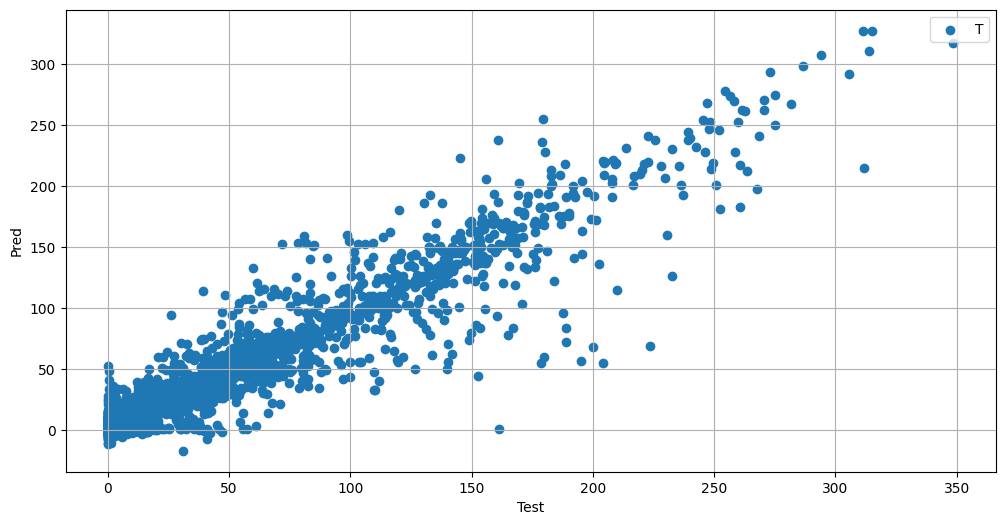

In [ ]:
lr4 = LinearRegression()
lr4.fit(x_ff4_train, y_ff4_train)
predict_lr4 = lr4.predict(x_cluster4_test)

# MAE, R2 Score
r2 = r2_score(y_cluster4_test, predict_lr4)
mae = mean_absolute_error(y_cluster4_test, predict_lr4)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_lr4, columns=['Pred'])
y_test_new = y_cluster4_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Mean Absolute Error (MAE): 0.44
R-squared (R^2): 0.90
         Pred    Test
0    6.546987   6.660
1   11.603866  11.927
2    0.118813   0.000
3    0.023586   0.000
4    5.990605   6.146
5    0.237846   0.000
6    0.952857   0.989
7    0.689826   1.836
8   10.642606  11.640
9    0.190233   0.000
10   1.521826   1.410
11   0.166426   0.000
12   0.540451   0.298
13  -0.024027   0.000
14   0.115822   0.047
15   0.714226   2.222
16  -0.035930   0.000
17   0.536021   0.457
18   0.225943   0.000
19   5.464073   6.448
20   5.962827   5.567
21   0.225943   0.000
22   0.071200   0.000
23   1.485799   1.396
24   5.747722   5.855
25   0.037580   0.000
26   0.214040   0.000
27   0.124632   0.000
28   6.363963   6.951
29   0.631839   0.661
30   0.362600   0.252
31   5.556102   3.620
32   0.619808   0.776
33   0.750584   0.564
34  -0.000220   0.000
35   0.088420   0.130
36   1.573312   1.615
37   4.156995   1.308
38   6.320148   6.289
39   0.166426   0.000
40   0.311204   0.446
41   0.407723   0.048


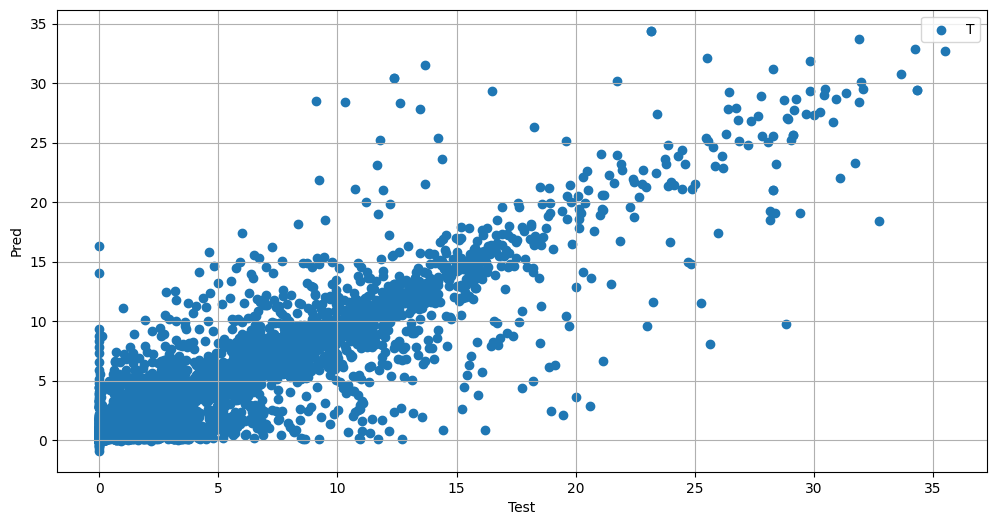

In [ ]:
lr3 = LinearRegression()
lr3.fit(x_ff3_train, y_ff3_train)
predict_lr3 = lr3.predict(x_cluster3_test)

# MAE, R2 Score
r2 = r2_score(y_cluster3_test, predict_lr3)
mae = mean_absolute_error(y_cluster3_test, predict_lr3)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_lr3, columns=['Pred'])
y_test_new = y_cluster3_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

# SVR

In [ ]:
params = {'C': [1, 5, 10], 'kernel': ['linear', 'rbf']}
sv1 = SVR()
sg_v1 = GridSearchCV(sv1, param_grid=params, refit=True, verbose=5, cv=TimeSeriesSplit(n_splits=5).split(x_ff1_train))
sg_v1.fit(x_ff1_train, y_ff1_train)

model_sgv1 = sg_v1.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................C=1, kernel=linear;, score=0.861 total time=  32.9s
[CV 2/5] END ................C=1, kernel=linear;, score=0.858 total time= 1.8min
[CV 3/5] END ................C=1, kernel=linear;, score=0.864 total time= 4.0min
[CV 4/5] END ................C=1, kernel=linear;, score=0.860 total time= 7.1min
[CV 5/5] END ................C=1, kernel=linear;, score=0.851 total time=11.1min
[CV 1/5] END ...................C=1, kernel=rbf;, score=0.815 total time=  20.2s
[CV 2/5] END ...................C=1, kernel=rbf;, score=0.827 total time= 1.1min
[CV 3/5] END ...................C=1, kernel=rbf;, score=0.838 total time= 2.1min
[CV 4/5] END ...................C=1, kernel=rbf;, score=0.844 total time= 3.6min
[CV 5/5] END ...................C=1, kernel=rbf;, score=0.851 total time=36.3min
[CV 1/5] END ................C=5, kernel=linear;, score=0.861 total time= 1.3min
[CV 2/5] END ................C=5, kernel=linear;,

In [ ]:
predict_sgv1 = model_sgv1.predict(x_cluster1_test)

# MAE, R2 Score
r2 = r2_score(y_cluster1_test, predict_sgv1)
mae = mean_absolute_error(y_cluster1_test, predict_sgv1)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_sgv1, columns=['Pred'])
y_test_new = y_cluster1_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

In [ ]:
params = {'C': [1, 5, 10], 'kernel': ['linear', 'rbf']}
sv3 = SVR()
sg_v3 = GridSearchCV(sv3, param_grid=params, refit=True, verbose=5, cv=TimeSeriesSplit(n_splits=5).split(x_ff1_train))
sg_v3.fit(x_ff3_train, y_ff3_train)

model_sgv3 = sg_v3.best_estimator_

predict_sgv3 = model_sgv3.predict(x_cluster3_test)

# MAE, R2 Score
r2 = r2_score(y_cluster3_test, predict_sgv3)
mae = mean_absolute_error(y_cluster3_test, predict_sgv3)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_sgv3, columns=['Pred'])
y_test_new = y_cluster3_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

In [ ]:
params = {'C': [1, 5, 10], 'kernel': ['linear', 'rbf']}
sv4 = SVR()
sg_v4 = GridSearchCV(sv4, param_grid=params, refit=True, verbose=5, cv=TimeSeriesSplit(n_splits=5).split(x_ff1_train))
sg_v4.fit(x_ff4_train, y_ff4_train)

model_sgv4 = sg_v4.best_estimator_

predict_sgv4 = model_sgv4.predict(x_cluster4_test)

# MAE, R2 Score
r2 = r2_score(y_cluster4_test, predict_sgv4)
mae = mean_absolute_error(y_cluster4_test, predict_sgv4)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_sgv4, columns=['Pred'])
y_test_new = y_cluster4_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

# LSTM

In [ ]:
model_lstm1 = Sequential()
model_lstm1.add(LSTM(units=50, activation='relu', input_shape=(x_ff1_train.shape[1], 1)))
model_lstm1.add(Dense(units=1))  # 하나의 종속 변수에 대해 하나의 뉴런이 있는 출력 레이어

model_lstm1.compile(optimizer='adam', loss='mean_squared_error')

model_lstm1.fit(x_ff1_train, y_ff1_train, epochs=50, batch_size=32)

Epoch 1/50
3640/3640 [==============================] - 27s 6ms/step - loss: 5.1701
Epoch 2/50
3640/3640 [==============================] - 19s 5ms/step - loss: 3.9242
Epoch 3/50
3640/3640 [==============================] - 32s 9ms/step - loss: 3.7532
Epoch 4/50
3640/3640 [==============================] - 30s 8ms/step - loss: 3.6790
Epoch 5/50
3640/3640 [==============================] - 23s 6ms/step - loss: 3.5699
Epoch 6/50
3640/3640 [==============================] - 23s 6ms/step - loss: 3.4397
Epoch 7/50
3640/3640 [==============================] - 25s 7ms/step - loss: 3.2580
Epoch 8/50
3640/3640 [==============================] - 29s 8ms/step - loss: 3.1194
Epoch 9/50
3640/3640 [==============================] - 20s 6ms/step - loss: 2.9604
Epoch 10/50
3640/3640 [==============================] - 26s 7ms/step - loss: 2.8334
Epoch 11/50
3640/3640 [==============================] - 23s 6ms/step - loss: 2.7977
Epoch 12/50
3640/3640 [==============================] - 20s 6ms/step - lo

910/910 [==============================] - 2s 3ms/step
Mean Absolute Error (MAE): 0.58
R-squared (R^2): 0.92
910/910 [==============================] - 2s 2ms/step
         Pred    Test
0    0.102281   0.000
1    1.812215   1.309
2    0.598543   0.294
3    1.026317   0.984
4   13.772142  14.998
5   15.736213  13.902
6    2.795245   3.980
7    3.075289   1.429
8    3.209465   3.838
9    0.069250   0.000
10   0.858898   0.535
11   3.617245  12.110
12   0.763704   0.545
13   0.985708   0.000
14   2.737936   3.190
15   0.552162   0.616
16   0.003654   0.000
17   0.683269   0.448
18   1.361974   1.444
19   1.495814   2.280
20   0.241294   0.000
21   2.438681   0.320
22   0.532642   0.460
23   0.102281   0.000
24   0.657017   0.690
25   0.512038   0.426
26   0.559753   0.600
27   1.158481   3.038
28   0.102281   0.000
29   0.901667   0.000
30   0.649952   0.778
31   0.584554   0.701
32  17.411793  17.540
33  -0.054042   0.000
34   6.156035   7.020
35   2.112496   2.357
36   0.347386   0.191


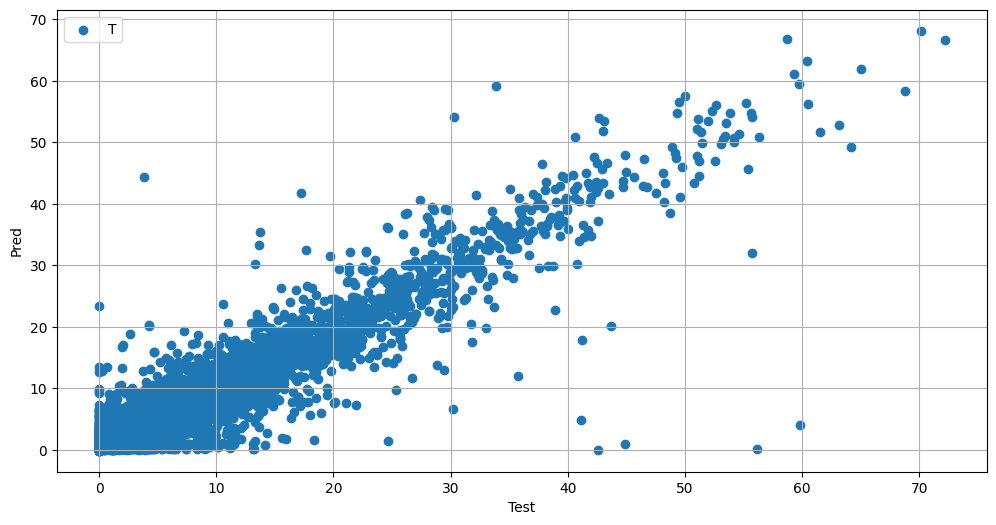

In [ ]:
# MAE, R2 Score
r2 = r2_score(y_cluster1_test, model_lstm1.predict(x_cluster1_test))
mae = mean_absolute_error(y_cluster1_test, model_lstm1.predict(x_cluster1_test))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(model_lstm1.predict(x_cluster1_test), columns=['Pred'])
y_test_new = y_cluster1_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Epoch 1/50
2495/2495 [==============================] - 13s 5ms/step - loss: 2.3512
Epoch 2/50
2495/2495 [==============================] - 10s 4ms/step - loss: 1.6355
Epoch 3/50
2495/2495 [==============================] - 13s 5ms/step - loss: 1.5578
Epoch 4/50
2495/2495 [==============================] - 18s 7ms/step - loss: 1.5190
Epoch 5/50
2495/2495 [==============================] - 15s 6ms/step - loss: 1.5021
Epoch 6/50
2495/2495 [==============================] - 15s 6ms/step - loss: 1.4832
Epoch 7/50
2495/2495 [==============================] - 18s 7ms/step - loss: 1.4522
Epoch 8/50
2495/2495 [==============================] - 20s 8ms/step - loss: 1.4331
Epoch 9/50
2495/2495 [==============================] - 19s 8ms/step - loss: 1.3815
Epoch 10/50
2495/2495 [==============================] - 18s 7ms/step - loss: 1.3424
Epoch 11/50
2495/2495 [==============================] - 13s 5ms/step - loss: 1.2972
Epoch 12/50
2495/2495 [==============================] - 17s 7ms/step - lo

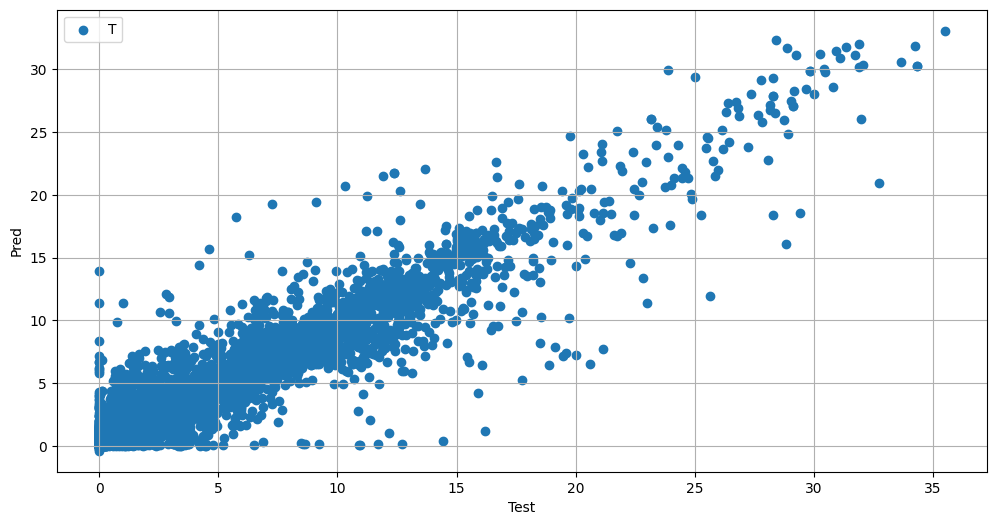

In [ ]:
model_lstm3 = Sequential()
model_lstm3.add(LSTM(units=50, activation='relu', input_shape=(x_ff3_train.shape[1], 1)))
model_lstm3.add(Dense(units=1))  # 하나의 종속 변수에 대해 하나의 뉴런이 있는 출력 레이어

model_lstm3.compile(optimizer='adam', loss='mean_squared_error')

model_lstm3.fit(x_ff3_train, y_ff3_train, epochs=50, batch_size=32)

# MAE, R2 Score
r2 = r2_score(y_cluster3_test, model_lstm3.predict(x_cluster3_test))
mae = mean_absolute_error(y_cluster3_test, model_lstm3.predict(x_cluster3_test))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(model_lstm3.predict(x_cluster3_test), columns=['Pred'])
y_test_new = y_cluster3_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Epoch 1/50
4020/4020 [==============================] - 19s 4ms/step - loss: 52.9371
Epoch 2/50
4020/4020 [==============================] - 29s 7ms/step - loss: 37.7494
Epoch 3/50
4020/4020 [==============================] - 20s 5ms/step - loss: 36.2673
Epoch 4/50
4020/4020 [==============================] - 20s 5ms/step - loss: 34.8782
Epoch 5/50
4020/4020 [==============================] - 17s 4ms/step - loss: 34.0562
Epoch 6/50
4020/4020 [==============================] - 19s 5ms/step - loss: 33.0280
Epoch 7/50
4020/4020 [==============================] - 18s 5ms/step - loss: 32.3088
Epoch 8/50
4020/4020 [==============================] - 17s 4ms/step - loss: 30.8203
Epoch 9/50
4020/4020 [==============================] - 20s 5ms/step - loss: 30.4905
Epoch 10/50
4020/4020 [==============================] - 32s 8ms/step - loss: 28.8350
Epoch 11/50
4020/4020 [==============================] - 19s 5ms/step - loss: 28.1567
Epoch 12/50
4020/4020 [==============================] - 19s 5m

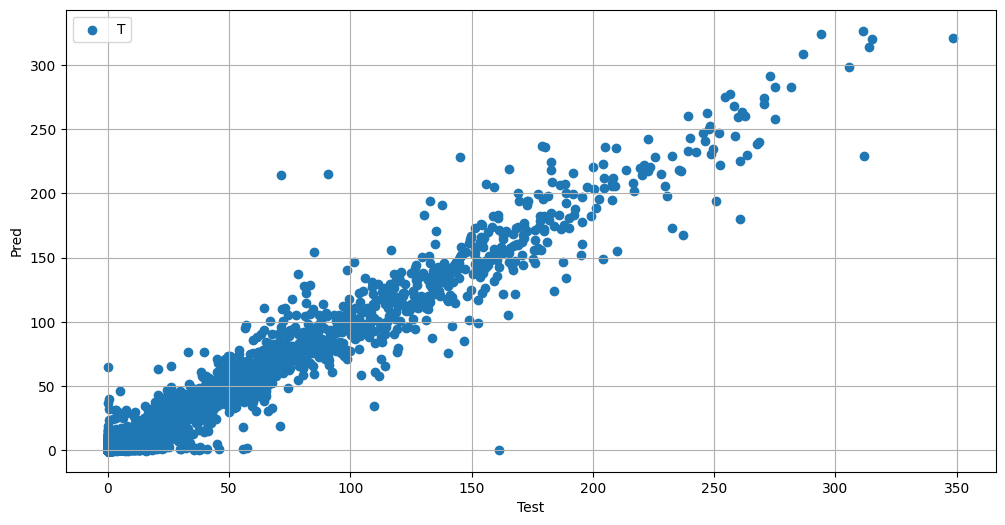

In [ ]:
model_lstm4 = Sequential()
model_lstm4.add(LSTM(units=50, activation='relu', input_shape=(x_ff4_train.shape[1], 1)))
model_lstm4.add(Dense(units=1))  # 하나의 종속 변수에 대해 하나의 뉴런이 있는 출력 레이어

model_lstm4.compile(optimizer='adam', loss='mean_squared_error')

model_lstm4.fit(x_ff4_train, y_ff4_train, epochs=50, batch_size=32)

# MAE, R2 Score
r2 = r2_score(y_cluster4_test, model_lstm4.predict(x_cluster4_test))
mae = mean_absolute_error(y_cluster4_test, model_lstm4.predict(x_cluster4_test))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(model_lstm4.predict(x_cluster4_test), columns=['Pred'])
y_test_new = y_cluster4_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

# Random Forest

In [ ]:
rf1 = RandomForestRegressor(random_state=42, verbose=1)

param_grid = {
    'n_estimators': [200],  # 트리 개수
    'max_depth': [10],  # 트리 최대 깊이
    'min_samples_split': [10],  # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1],  # 최소 샘플 수
    'max_features': ['auto'],  # 분할 시 고려할 특성
    'bootstrap': [True]  # bootstrap(재표본추출) 사용
}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   24.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


Mean Absolute Error (MAE): 0.54
R-squared (R^2): 0.92
         Pred    Test
0    0.097031   0.000
1    1.012444   1.309
2    0.483897   0.294
3    1.000286   0.984
4   13.110511  14.998
5   14.023220  13.902
6    2.390144   3.980
7    3.470651   1.429
8    3.366419   3.838
9    0.004431   0.000
10   0.568924   0.535
11   5.799846  12.110
12   0.656188   0.545
13   0.971513   0.000
14   3.041533   3.190
15   0.662536   0.616
16   0.000151   0.000
17   0.728596   0.448
18   1.435223   1.444
19   2.115729   2.280
20   0.278674   0.000
21   2.525015   0.320
22   0.546496   0.460
23   0.097031   0.000
24   0.667902   0.690
25   0.555438   0.426
26   0.493702   0.600
27   0.509261   3.038
28   0.097031   0.000
29   0.851089   0.000
30   0.816967   0.778
31   0.784646   0.701
32  18.369821  17.540
33   0.003469   0.000
34   6.246607   7.020
35   2.614905   2.357
36   0.174611   0.191
37   0.824319   0.803
38   4.146549   4.391
39   0.000000   0.000
40   0.860973   1.036
41   3.434776   3.548


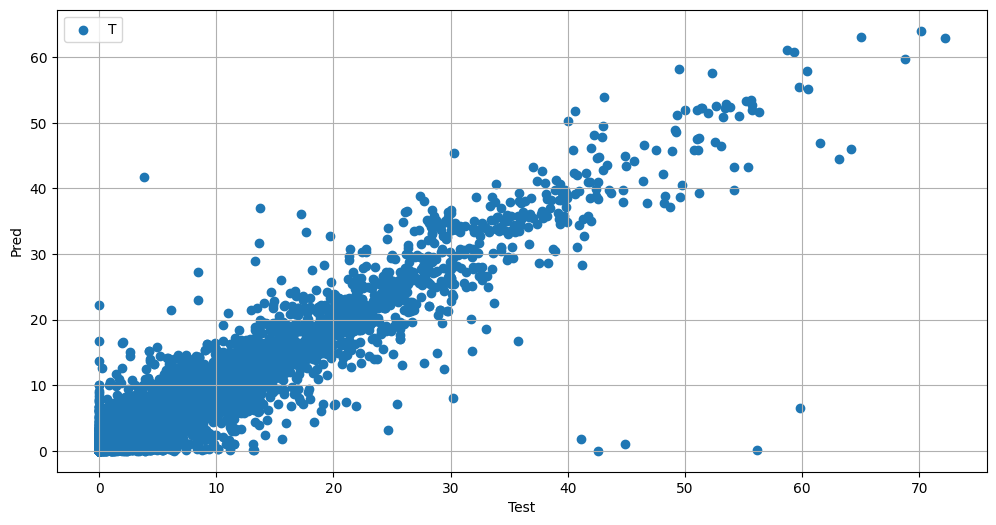

In [ ]:
grid_search1 = GridSearchCV(estimator=rf1,
                           param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=-1)

grid_search1.fit(x_ff1_train, y_ff1_train)


best_params_rf1 = grid_search1.best_params_
best_score_rf1 = np.sqrt(-grid_search1.best_score_)  # 음수 MSE를 양수 변환 후 RMSE


# 최적 하이퍼파라미터 사용하여 예측
best_rf1 = grid_search1.best_estimator_

predict_rf1 = best_rf1.predict(x_cluster1_test)

# MAE, R2 Score
r2 = r2_score(y_cluster1_test, predict_rf1)
mae = mean_absolute_error(y_cluster1_test, predict_rf1)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_rf1, columns=['Pred'])
y_test_new = y_cluster1_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   33.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


Mean Absolute Error (MAE): 0.33
R-squared (R^2): 0.93
         Pred    Test
0    6.793029   6.660
1   11.989710  11.927
2    0.057215   0.000
3    0.010775   0.000
4    6.120979   6.146
5    0.002314   0.000
6    0.946461   0.989
7    1.099635   1.836
8   10.918866  11.640
9    0.006320   0.000
10   1.451519   1.410
11   0.008650   0.000
12   0.492078   0.298
13   0.010307   0.000
14   0.063165   0.047
15   0.825711   2.222
16   0.010254   0.000
17   0.758795   0.457
18   0.004520   0.000
19   5.968463   6.448
20   6.298101   5.567
21   0.004520   0.000
22   0.054829   0.000
23   1.450315   1.396
24   5.880118   5.855
25   0.012603   0.000
26   0.008487   0.000
27   0.062205   0.000
28   7.397159   6.951
29   0.754563   0.661
30   0.270676   0.252
31   6.237084   3.620
32   0.696670   0.776
33   0.605258   0.564
34   0.010295   0.000
35   0.138974   0.130
36   1.666210   1.615
37   3.532479   1.308
38   6.389251   6.289
39   0.008650   0.000
40   0.262478   0.446
41   1.111439   0.048


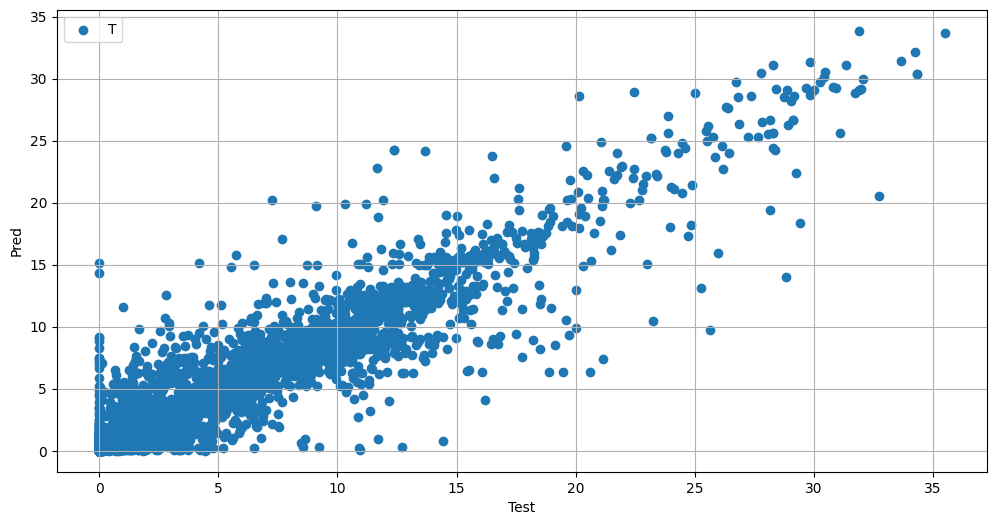

In [ ]:
rf3 = RandomForestRegressor(random_state=42, verbose=1)

param_grid = {
    'n_estimators': [200],  # 트리 개수
    'max_depth': [10],  # 트리 최대 깊이
    'min_samples_split': [10],  # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1],  # 최소 샘플 수
    'max_features': ['auto'],  # 분할 시 고려할 특성
    'bootstrap': [True]  # bootstrap(재표본추출) 사용
}

grid_search3 = GridSearchCV(estimator=rf3,
                           param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=-1)

grid_search3.fit(x_ff3_train, y_ff3_train)


best_params_rf3 = grid_search3.best_params_
best_score_rf3 = np.sqrt(-grid_search3.best_score_)  # 음수 MSE를 양수 변환 후 RMSE


# 최적 하이퍼파라미터 사용하여 예측
best_rf3 = grid_search3.best_estimator_

predict_rf3 = best_rf3.predict(x_cluster3_test)

# MAE, R2 Score
r2 = r2_score(y_cluster3_test, predict_rf3)
mae = mean_absolute_error(y_cluster3_test, predict_rf3)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_rf3, columns=['Pred'])
y_test_new = y_cluster3_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   22.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


Mean Absolute Error (MAE): 1.06
R-squared (R^2): 0.96
         Pred    Test
0    0.073587   0.000
1    8.975306   0.000
2    0.019914   0.000
3    0.019914   0.000
4    3.414975   3.709
5    0.630777   0.642
6    2.837482  13.024
7    0.043574   0.000
8    3.522397   3.691
9    0.168851   0.000
10   0.019914   0.000
11   0.940140   0.811
12   0.168851   0.000
13  70.143924  69.000
14   1.890317   1.711
15   0.020054   0.000
16   0.019995   0.000
17  10.112772  17.431
18   8.511682   8.155
19   0.001421   0.000
20  11.641445  13.082
21   0.888933   0.726
22   0.583643   0.157
23  16.419007  16.176
24   0.111514   0.000
25   0.079758   0.000
26  11.660778  15.022
27   0.054822   0.000
28   0.366347   0.000
29   6.216750   6.710
30   6.011428   5.332
31   0.630777   0.570
32   0.032392   0.000
33   0.045368   0.000
34   6.678534   6.356
35   0.019914   0.000
36   4.206029   6.617
37   0.152679   0.001
38  32.876520  34.837
39   0.366347   0.000
40   1.284212   0.895
41   0.054822   0.000


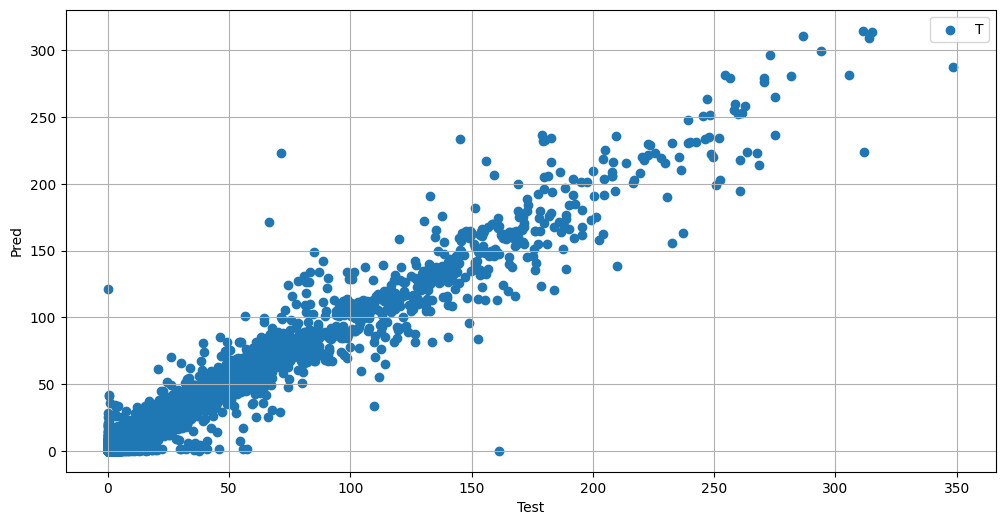

In [ ]:
rf4 = RandomForestRegressor(random_state=42, verbose=1)

param_grid = {
    'n_estimators': [200],  # 트리 개수
    'max_depth': [10],  # 트리 최대 깊이
    'min_samples_split': [10],  # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1],  # 최소 샘플 수
    'max_features': ['auto'],  # 분할 시 고려할 특성
    'bootstrap': [True]  # bootstrap(재표본추출) 사용
}

grid_search4 = GridSearchCV(estimator=rf4,
                           param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=-1)

grid_search4.fit(x_ff4_train, y_ff4_train)


best_params_rf4 = grid_search4.best_params_
best_score_rf4 = np.sqrt(-grid_search4.best_score_)  # 음수 MSE를 양수 변환 후 RMSE


# 최적 하이퍼파라미터 사용하여 예측
best_rf4 = grid_search4.best_estimator_

predict_rf4 = best_rf4.predict(x_cluster4_test)

# MAE, R2 Score
r2 = r2_score(y_cluster4_test, predict_rf4)
mae = mean_absolute_error(y_cluster4_test, predict_rf4)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_rf4, columns=['Pred'])
y_test_new = y_cluster4_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

# LGBMRegressor

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 116470, number of used features: 5
[LightGBM] [Info] Start training from score 2.826267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

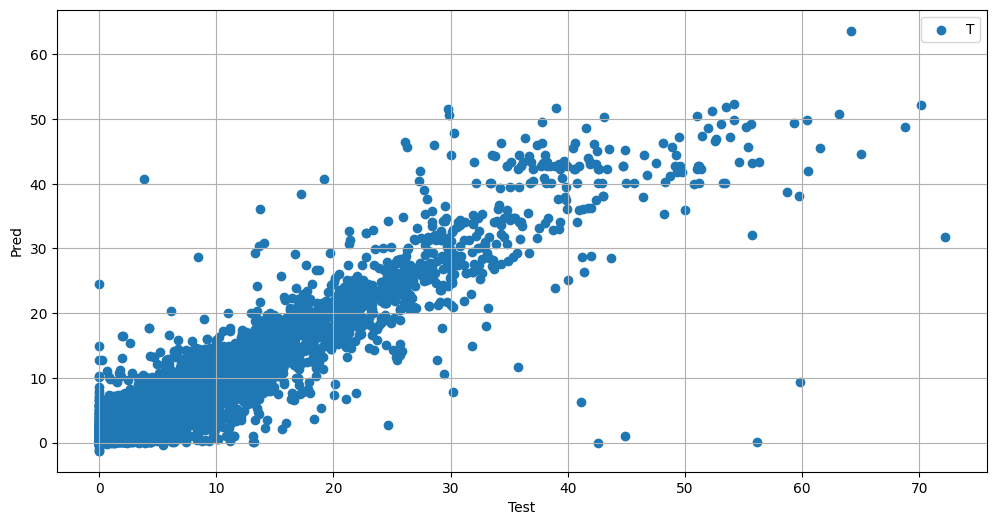

In [ ]:
param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5]
}

lgbm1 = lgb.LGBMRegressor(random_state=42)

grid_search1 = GridSearchCV(
    lgbm1, param_grid_lgbm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search1.fit(x_ff1_train, y_ff1_train)

best_params1 = grid_search1.best_params_

best_lgbm1 = lgb.LGBMRegressor(**best_params1, random_state=42)
best_lgbm1.fit(x_ff1_train, y_ff1_train)

predict_lgbm1 = best_lgbm1.predict(x_cluster1_test)

# MAE, R2 Score
r2 = r2_score(y_cluster1_test, predict_lgbm1)
mae = mean_absolute_error(y_cluster1_test, predict_lgbm1)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_lgbm1, columns=['Pred'])
y_test_new = y_cluster1_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 79822, number of used features: 5
[LightGBM] [Info] Start training from score 2.186415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

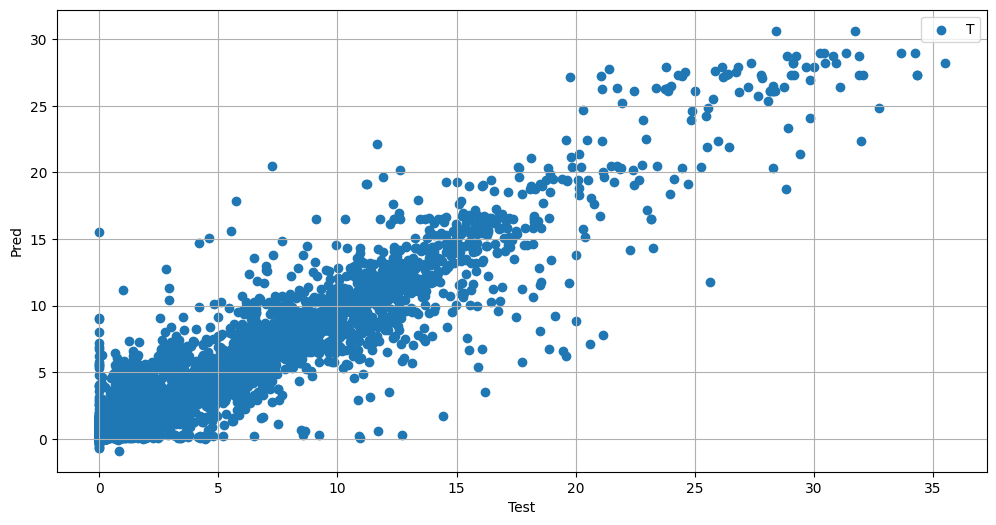

In [ ]:
param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5]
}

lgbm3 = lgb.LGBMRegressor(random_state=42)

grid_search3 = GridSearchCV(
    lgbm3, param_grid_lgbm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search3.fit(x_ff3_train, y_ff3_train)

best_params3 = grid_search3.best_params_

best_lgbm3 = lgb.LGBMRegressor(**best_params3, random_state=42)
best_lgbm3.fit(x_ff3_train, y_ff3_train)

predict_lgbm3 = best_lgbm3.predict(x_cluster3_test)

# MAE, R2 Score
r2 = r2_score(y_cluster3_test, predict_lgbm3)
mae = mean_absolute_error(y_cluster3_test, predict_lgbm3)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_lgbm3, columns=['Pred'])
y_test_new = y_cluster3_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 116470, number of used features: 5
[LightGBM] [Info] Start training from score 2.826267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

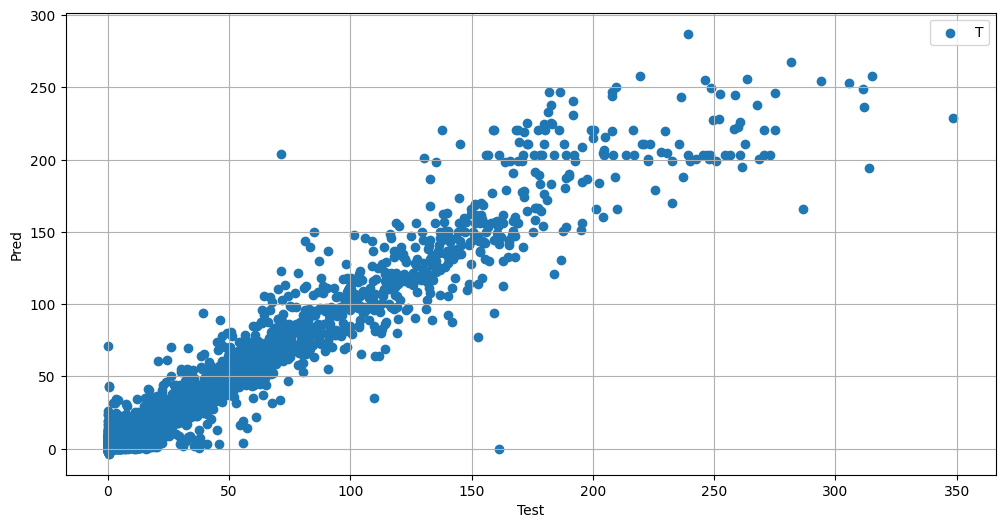

In [ ]:
param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5]
}

lgbm4 = lgb.LGBMRegressor(random_state=42)

grid_search4 = GridSearchCV(
    lgbm4, param_grid_lgbm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search4.fit(x_ff1_train, y_ff1_train)

best_params4 = grid_search4.best_params_

best_lgbm4 = lgb.LGBMRegressor(**best_params4, random_state=42)
best_lgbm4.fit(x_ff4_train, y_ff4_train)

predict_lgbm4 = best_lgbm4.predict(x_cluster4_test)

# MAE, R2 Score
r2 = r2_score(y_cluster4_test, predict_lgbm4)
mae = mean_absolute_error(y_cluster4_test, predict_lgbm4)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_lgbm4, columns=['Pred'])
y_test_new = y_cluster4_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

# MLPRegressor

In [ ]:
# MLPRegressor 모델
model_mlp1 = MLPRegressor(
    hidden_layer_sizes=(64, 32),  # 'hidden_layer_sizes' 설정
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=1000  # max_iter 파라미터가 모델이 수렴할 때까지의 최대 반복 횟수를 설정
)

Mean Absolute Error (MAE): 0.65
R-squared (R^2): 0.91
         Pred    Test
0   -0.186815   0.000
1    0.753297   1.309
2    0.236628   0.294
3    0.947667   0.984
4   13.935962  14.998
5   16.312977  13.902
6    3.100565   3.980
7    3.062383   1.429
8    3.770803   3.838
9   -0.039892   0.000
10   0.526749   0.535
11   4.869181  12.110
12   0.535068   0.545
13   0.674124   0.000
14   3.267165   3.190
15   0.342042   0.616
16  -0.311776   0.000
17   0.096864   0.448
18   1.205799   1.444
19   1.888894   2.280
20  -0.147333   0.000
21   2.999103   0.320
22   0.268749   0.460
23  -0.186815   0.000
24   0.363119   0.690
25   0.176422   0.426
26   0.266754   0.600
27   1.045900   3.038
28  -0.186815   0.000
29   0.782980   0.000
30   0.613030   0.778
31   0.400284   0.701
32  18.625847  17.540
33  -0.334536   0.000
34   6.466304   7.020
35   2.041033   2.357
36   0.000342   0.191
37   0.779420   0.803
38   4.647499   4.391
39  -0.350788   0.000
40   0.785169   1.036
41   3.003396   3.548


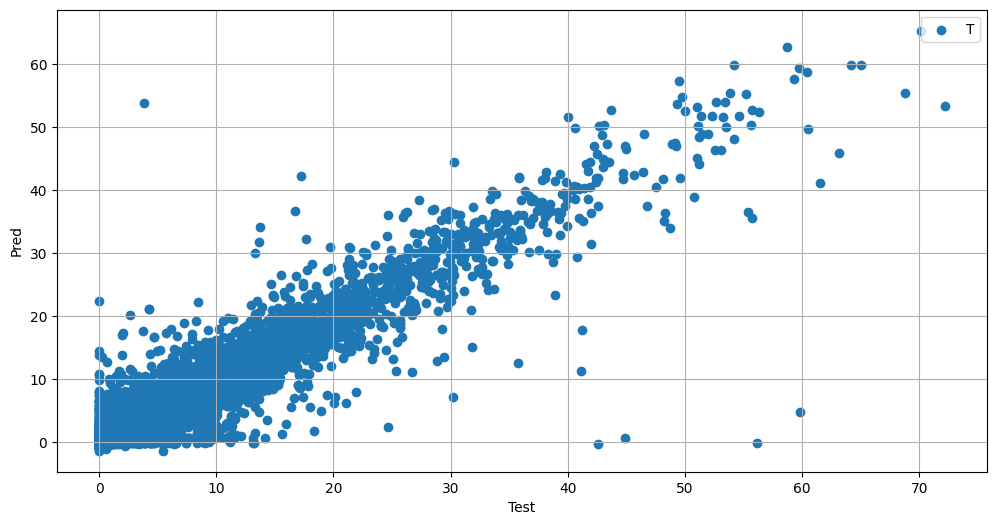

In [ ]:
# MLPRegressor 모델을 훈련
model_mlp1.fit(x_ff1_train, y_ff1_train)

predict_mlp1 = model_mlp1.predict(x_cluster1_test)

# MAE, R2 Score
r2 = r2_score(y_cluster1_test, predict_mlp1)
mae = mean_absolute_error(y_cluster1_test, predict_mlp1)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_mlp1, columns=['Pred'])
y_test_new = y_cluster1_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Mean Absolute Error (MAE): 0.41
R-squared (R^2): 0.94
         Pred    Test
0    6.856885   6.660
1   11.058236  11.927
2    0.039723   0.000
3    0.036229   0.000
4    6.179591   6.146
5    0.292838   0.000
6    0.701557   0.989
7    1.298621   1.836
8    8.567144  11.640
9    0.193426   0.000
10   1.600258   1.410
11   0.173861   0.000
12   0.581804   0.298
13   0.047076   0.000
14   0.071776   0.047
15   0.828602   2.222
16   0.042020   0.000
17   0.482675   0.457
18   0.301212   0.000
19   5.530847   6.448
20   6.182696   5.567
21   0.301212   0.000
22   0.028843   0.000
23   1.660223   1.396
24   6.086759   5.855
25   0.016389   0.000
26   0.234094   0.000
27   0.151298   0.000
28   8.145143   6.951
29   0.559262   0.661
30   0.644612   0.252
31   5.690949   3.620
32   0.696314   0.776
33   0.779368   0.564
34   0.057190   0.000
35   0.147209   0.130
36   1.168940   1.615
37   3.175944   1.308
38   6.688308   6.289
39   0.173861   0.000
40   0.013787   0.446
41   0.104281   0.048


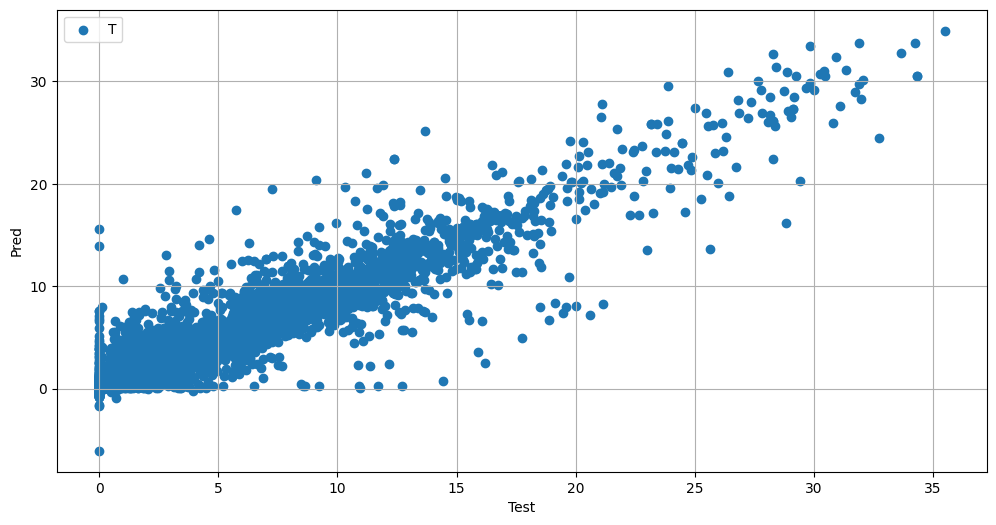

In [ ]:
model_mlp3 = MLPRegressor(
    hidden_layer_sizes=(64, 32),  # 'hidden_layer_sizes' 설정
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=1000  # max_iter 파라미터가 모델이 수렴할 때까지의 최대 반복 횟수를 설정
)

model_mlp3.fit(x_ff3_train, y_ff3_train)

predict_mlp3 = model_mlp3.predict(x_cluster3_test)

# MAE, R2 Score
r2 = r2_score(y_cluster3_test, predict_mlp3)
mae = mean_absolute_error(y_cluster3_test, predict_mlp3)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_mlp3, columns=['Pred'])
y_test_new = y_cluster3_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Mean Absolute Error (MAE): 1.59
R-squared (R^2): 0.96
         Pred    Test
0   -0.433263   0.000
1    5.776954   0.000
2   -0.315301   0.000
3   -0.315301   0.000
4    3.083143   3.709
5    0.248909   0.642
6    1.324661  13.024
7   -0.695873   0.000
8    3.542661   3.691
9   -0.479440   0.000
10  -0.315301   0.000
11  -0.411062   0.811
12  -0.479440   0.000
13  71.154980  69.000
14   2.351074   1.711
15  -0.148155   0.000
16  -0.313946   0.000
17  14.200369  17.431
18   7.173103   8.155
19  -1.190515   0.000
20  10.871040  13.082
21  -0.620567   0.726
22  -1.230525   0.157
23  16.052014  16.176
24  -0.345555   0.000
25  -0.377381   0.000
26   9.632853  15.022
27  -0.308646   0.000
28   0.319447   0.000
29   5.875705   6.710
30   5.601720   5.332
31   0.580840   0.570
32  -0.367097   0.000
33  -0.699024   0.000
34   5.855358   6.356
35  -0.315301   0.000
36   5.987897   6.617
37   1.522156   0.001
38  34.524242  34.837
39   0.319447   0.000
40  -0.061903   0.895
41  -0.308646   0.000


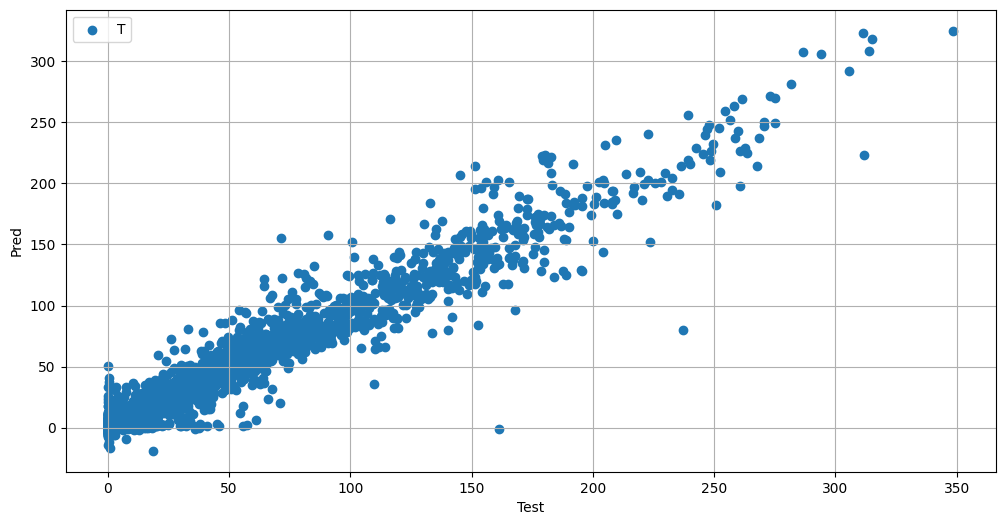

In [ ]:
model_mlp4 = MLPRegressor(
    hidden_layer_sizes=(64, 32),  # 'hidden_layer_sizes' 설정
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=1000  # max_iter 파라미터가 모델이 수렴할 때까지의 최대 반복 횟수를 설정
)

model_mlp4.fit(x_ff4_train, y_ff4_train)

predict_mlp4 = model_mlp4.predict(x_cluster4_test)

# MAE, R2 Score
r2 = r2_score(y_cluster4_test, predict_mlp4)
mae = mean_absolute_error(y_cluster4_test, predict_mlp4)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_mlp4, columns=['Pred'])
y_test_new = y_cluster4_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

# Gradient Boosting

Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
Mean Absolute Error (MAE): 0.57
R-squared (R^2): 0.92
         Pred    Test
0    0.085211   0.000
1    1.986153   1.309
2    0.402478   0.294
3    0.954314   0.984
4   13.253113  14.998
5   14.154628  13.902
6    2.637210   3.980
7    3.012584   1.429
8    3.339550   3.838
9    0.099800   0.000
10   0.742586   0.535
11   5.060144  12.110
12   0.860556   0.545
13   0.907451   0.000
14   2.916952   3.190
15   0.640007   0.616
16   0.008606   0.000
17   0.603134   0.448
18   1.358642   1.444
19   1.773296   2.280
20   0.361436   0.000
21   2.523915   0.320
22   0.491720   0.460
23   0.085211   0.000
24   0.687534   0.690
25   0.464475   0.426
26   0.421996   0.600
27   1.275764   3.038
28   0.085211   0.000
29   0.716201   0.000
30   0.821503   0.778
31   0.907838   0.701
32  17.707701  17.540
33   0.008606   0.000
34   6.266330   7.020
35   2.321429   2.357
36   0.264114   0.191
37   0.946170   0.803
38   4.4399

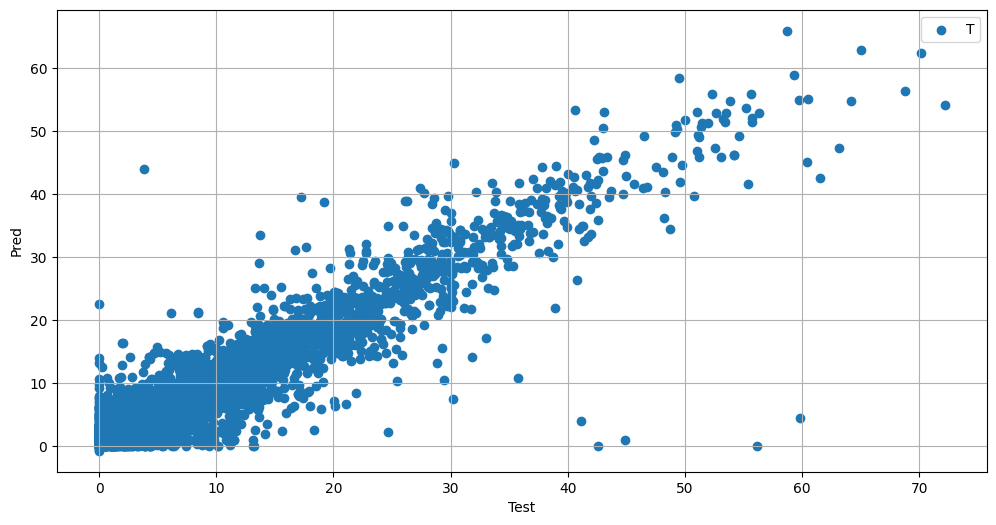

In [ ]:
param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5]
}

gbr1 = GradientBoostingRegressor(random_state=42)

grid_search1 = GridSearchCV(
    gbr1, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search1.fit(x_ff1_train, y_ff1_train)

best_params1 = grid_search1.best_params_
print(f'Лучшие параметры: {best_params1}')

best_gbr1 = GradientBoostingRegressor(**best_params1, random_state=42)
best_gbr1.fit(x_ff1_train, y_ff1_train)

predict_gbr1 = best_gbr1.predict(x_cluster1_test)

# MAE, R2 Score
r2 = r2_score(y_cluster1_test, predict_gbr1)
mae = mean_absolute_error(y_cluster1_test, predict_gbr1)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_gbr1, columns=['Pred'])
y_test_new = y_cluster1_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
Mean Absolute Error (MAE): 0.35
R-squared (R^2): 0.94
         Pred    Test
0    6.767317   6.660
1   11.555664  11.927
2    0.072102   0.000
3    0.007998   0.000
4    5.992413   6.146
5    0.012444   0.000
6    0.807951   0.989
7    0.986414   1.836
8    9.336031  11.640
9    0.012444   0.000
10   1.389434   1.410
11   0.012444   0.000
12   0.605362   0.298
13   0.019715   0.000
14   0.056444   0.047
15   1.802440   2.222
16   0.019715   0.000
17   0.609652   0.457
18   0.012444   0.000
19   5.669210   6.448
20   6.234013   5.567
21   0.012444   0.000
22   0.043461   0.000
23   1.389434   1.396
24   5.864693   5.855
25   0.062690   0.000
26   0.012444   0.000
27   0.151667   0.000
28   8.421319   6.951
29   0.678569   0.661
30   0.426228   0.252
31   6.086106   3.620
32   0.689465   0.776
33   0.590247   0.564
34   0.019715   0.000
35   0.141337   0.130
36   1.384846   1.615
37   3.048007   1.308
38   6.4537

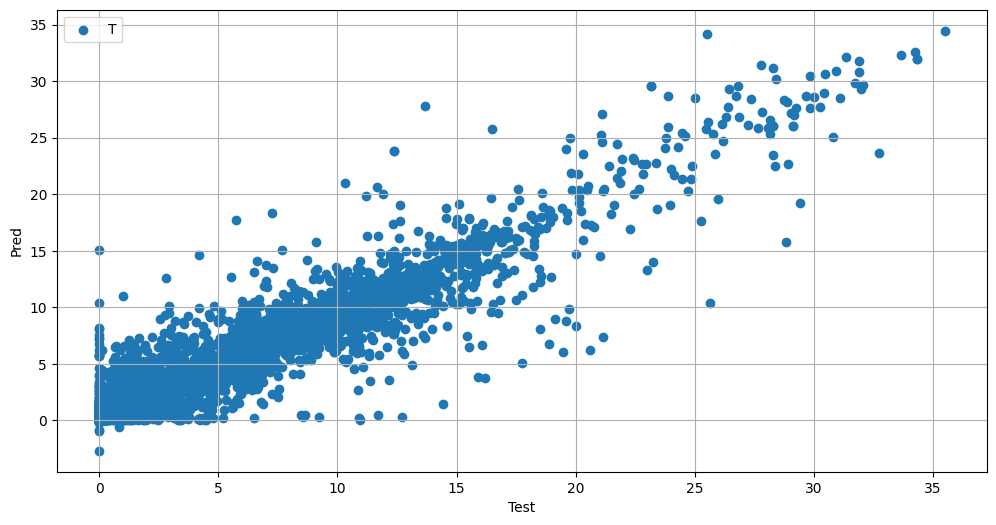

In [ ]:
gbr3 = GradientBoostingRegressor(random_state=42)

grid_search3 = GridSearchCV(
    gbr3, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search3.fit(x_ff3_train, y_ff3_train)

best_params3 = grid_search3.best_params_
print(f'Лучшие параметры: {best_params3}')

best_gbr3 = GradientBoostingRegressor(**best_params3, random_state=42)
best_gbr3.fit(x_ff3_train, y_ff3_train)

predict_gbr3 = best_gbr3.predict(x_cluster3_test)

# MAE, R2 Score
r2 = r2_score(y_cluster3_test, predict_gbr3)
mae = mean_absolute_error(y_cluster3_test, predict_gbr3)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_gbr3, columns=['Pred'])
y_test_new = y_cluster3_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
Mean Absolute Error (MAE): 1.13
R-squared (R^2): 0.97
         Pred    Test
0    0.218440   0.000
1   11.050501   0.000
2   -0.031322   0.000
3   -0.031322   0.000
4    3.336724   3.709
5    0.524075   0.642
6    3.387552  13.024
7    0.145758   0.000
8    3.232309   3.691
9    0.281112   0.000
10  -0.031322   0.000
11   0.873011   0.811
12   0.281112   0.000
13  69.413291  69.000
14   3.118037   1.711
15  -0.031322   0.000
16  -0.031322   0.000
17  12.880549  17.431
18   8.284023   8.155
19  -0.015979   0.000
20  12.224850  13.082
21   0.741179   0.726
22   1.076770   0.157
23  15.737054  16.176
24   0.281112   0.000
25   0.090246   0.000
26  10.026423  15.022
27   0.105933   0.000
28   0.569683   0.000
29   5.634078   6.710
30   5.984498   5.332
31   0.684875   0.570
32   0.054410   0.000
33   0.145758   0.000
34   6.521280   6.356
35  -0.031322   0.000
36   5.327246   6.617
37   0.875117   0.001
38  32.4744

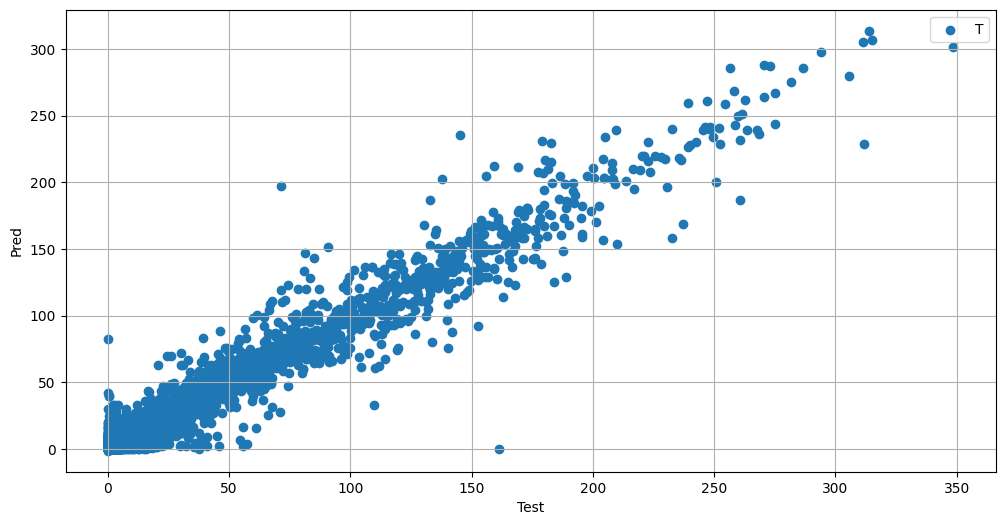

In [ ]:
gbr4 = GradientBoostingRegressor(random_state=42)

grid_search4 = GridSearchCV(
    gbr4, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search4.fit(x_ff4_train, y_ff4_train)

best_params4 = grid_search4.best_params_
print(f'Лучшие параметры: {best_params4}')

best_gbr4 = GradientBoostingRegressor(**best_params4, random_state=42)
best_gbr4.fit(x_ff4_train, y_ff4_train)

predict_gbr4 = best_gbr4.predict(x_cluster4_test)

# MAE, R2 Score
r2 = r2_score(y_cluster4_test, predict_gbr4)
mae = mean_absolute_error(y_cluster4_test, predict_gbr4)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_gbr4, columns=['Pred'])
y_test_new = y_cluster4_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

# Elastic Net

In [ ]:
elastic_net = ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=42)

elastic_net.fit(x_ff_train, y_ff_train)

ElasticNet(alpha=0.5, random_state=42)

Mean Absolute Error (MAE): 1.06
R-squared (R^2): 0.79
        Pred    Test
0   1.476144   0.907
1   2.979332   2.433
2   1.427031   4.364
3   0.784528   0.000
4   1.444289   0.754
5   1.658525   0.745
6   1.511618   0.903
7   1.419969   0.902
8   6.701843   1.330
9   1.432822   1.065
10  2.043638   1.744
11  1.616135   3.293
12  3.431959   6.188
13  1.413274   0.690
14  4.696170   1.974
15  2.955783   2.397
16  1.328701   0.745
17  0.784528   0.000
18  2.915713   1.880
19  0.784528   0.000
20  0.784528   0.000
21  2.745624   2.261
22  1.382853   0.783
23  1.509989   0.692
24  9.289847   9.718
25  1.463242   0.892
26  1.569750   0.780
27  0.784528   0.000
28  1.428874   3.076
29  4.676078   4.641
30  3.314290   2.455
31  2.292368   1.880
32  0.784528   0.000
33  1.399158   1.010
34  2.696784   1.894
35  3.515972   2.668
36  1.396812   0.739
37  1.849397   1.719
38  3.304045   2.437
39  1.453301   0.832
40  7.282726  12.005
41  2.570516   3.221
42  2.106801   2.036
43  6.837770   5.945
4

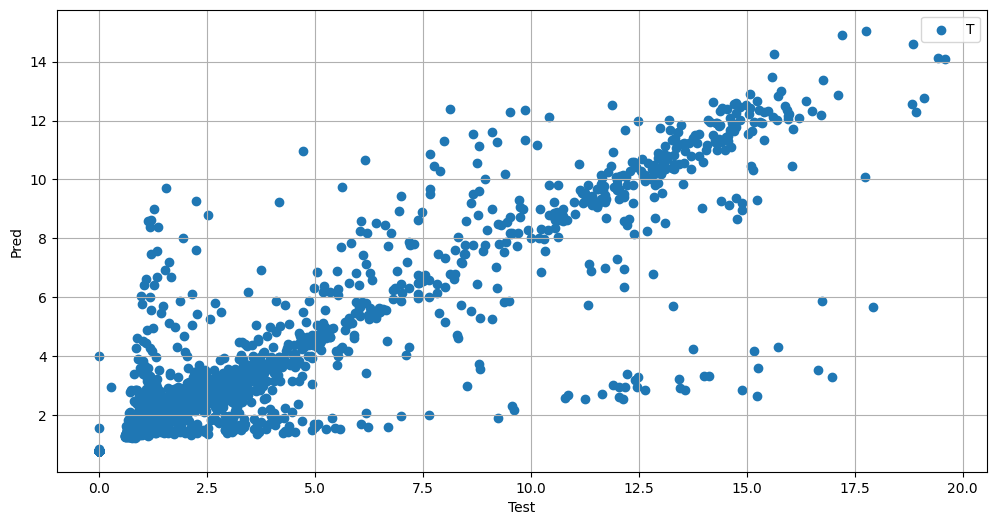

In [ ]:
result(elastic_net)

# Neural Network

Epoch 1/150
2912/2912 [==============================] - 7s 2ms/step - loss: 4.4914 - mae: 0.8109 - val_loss: 3.4299 - val_mae: 0.7989
Epoch 2/150
2912/2912 [==============================] - 7s 2ms/step - loss: 3.5177 - mae: 0.7297 - val_loss: 3.3666 - val_mae: 0.7112
Epoch 3/150
2912/2912 [==============================] - 8s 3ms/step - loss: 3.3872 - mae: 0.7183 - val_loss: 3.2955 - val_mae: 0.7430
Epoch 4/150
2912/2912 [==============================] - 7s 2ms/step - loss: 3.2863 - mae: 0.7093 - val_loss: 3.0789 - val_mae: 0.6929
Epoch 5/150
2912/2912 [==============================] - 6s 2ms/step - loss: 3.1772 - mae: 0.7034 - val_loss: 2.9603 - val_mae: 0.6604
Epoch 6/150
2912/2912 [==============================] - 7s 2ms/step - loss: 3.1085 - mae: 0.6940 - val_loss: 2.9858 - val_mae: 0.7999
Epoch 7/150
2912/2912 [==============================] - 7s 2ms/step - loss: 3.0304 - mae: 0.6884 - val_loss: 2.8600 - val_mae: 0.7206
Epoch 8/150
2912/2912 [==============================] 

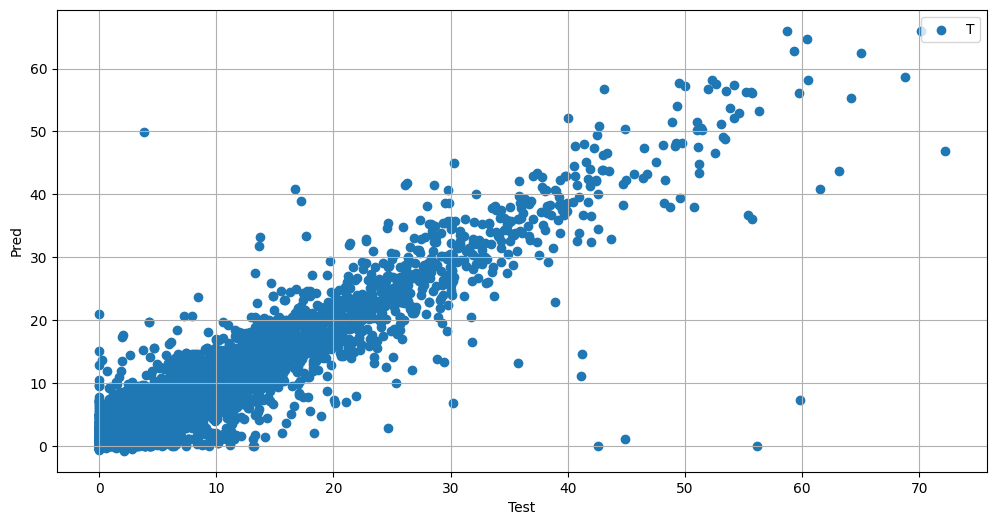

In [ ]:
x_train1, x_val1, y_train1, y_val1 = train_test_split(
    x_ff1_train, y_ff1_train, test_size=0.2, random_state=42)

model_nn1 = Sequential([
    Dense(64, activation='relu', input_shape=(5,)),
    Dense(32, activation='relu'),
    Dense(1)
])

model_nn1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history_nn1 = model_nn1.fit(x_train1, y_train1, epochs=150,
                            validation_data=(x_val1, y_val1))

# MAE, R2 Score
r2 = r2_score(y_cluster1_test, model_nn1.predict(x_cluster1_test))
mae = mean_absolute_error(y_cluster1_test, model_nn1.predict(x_cluster1_test))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(model_nn1.predict(x_cluster1_test), columns=['Pred'])
y_test_new = y_cluster1_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Epoch 1/150
1996/1996 [==============================] - 6s 3ms/step - loss: 1.8018 - mae: 0.5071 - val_loss: 1.5572 - val_mae: 0.4498
Epoch 2/150
1996/1996 [==============================] - 4s 2ms/step - loss: 1.4670 - mae: 0.4513 - val_loss: 1.4779 - val_mae: 0.4367
Epoch 3/150
1996/1996 [==============================] - 4s 2ms/step - loss: 1.4203 - mae: 0.4449 - val_loss: 1.5468 - val_mae: 0.4524
Epoch 4/150
1996/1996 [==============================] - 5s 3ms/step - loss: 1.3829 - mae: 0.4439 - val_loss: 1.3665 - val_mae: 0.4193
Epoch 5/150
1996/1996 [==============================] - 4s 2ms/step - loss: 1.3524 - mae: 0.4398 - val_loss: 1.3859 - val_mae: 0.4905
Epoch 6/150
1996/1996 [==============================] - 4s 2ms/step - loss: 1.3268 - mae: 0.4384 - val_loss: 1.3121 - val_mae: 0.4264
Epoch 7/150
1996/1996 [==============================] - 6s 3ms/step - loss: 1.2953 - mae: 0.4331 - val_loss: 1.3187 - val_mae: 0.4214
Epoch 8/150
1996/1996 [==============================] 

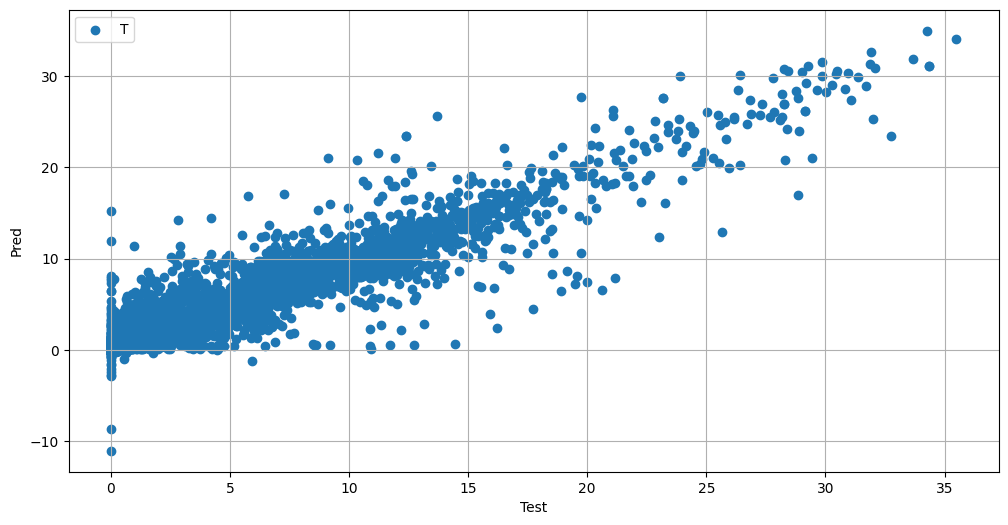

In [ ]:
x_train3, x_val3, y_train3, y_val3 = train_test_split(
    x_ff3_train, y_ff3_train, test_size=0.2, random_state=42)

model_nn3 = Sequential([
    Dense(64, activation='relu', input_shape=(5,)),
    Dense(32, activation='relu'),
    Dense(1)
])

model_nn3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history_nn3 = model_nn3.fit(x_train3, y_train3, epochs=150,
                            validation_data=(x_val3, y_val3))

# MAE, R2 Score
r2 = r2_score(y_cluster3_test, model_nn3.predict(x_cluster3_test))
mae = mean_absolute_error(y_cluster3_test, model_nn3.predict(x_cluster3_test))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(model_nn3.predict(x_cluster3_test), columns=['Pred'])
y_test_new = y_cluster3_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Epoch 1/150
3216/3216 [==============================] - 8s 2ms/step - loss: 64.0557 - mae: 1.9900 - val_loss: 33.4470 - val_mae: 1.5941
Epoch 2/150
3216/3216 [==============================] - 7s 2ms/step - loss: 36.6486 - mae: 1.6231 - val_loss: 30.9276 - val_mae: 1.6818
Epoch 3/150
3216/3216 [==============================] - 7s 2ms/step - loss: 35.4888 - mae: 1.6126 - val_loss: 40.1534 - val_mae: 1.9437
Epoch 4/150
3216/3216 [==============================] - 6s 2ms/step - loss: 34.5399 - mae: 1.5982 - val_loss: 29.7190 - val_mae: 1.5361
Epoch 5/150
3216/3216 [==============================] - 9s 3ms/step - loss: 33.7985 - mae: 1.5851 - val_loss: 29.1212 - val_mae: 1.5458
Epoch 6/150
3216/3216 [==============================] - 7s 2ms/step - loss: 33.1234 - mae: 1.5655 - val_loss: 28.9830 - val_mae: 1.5793
Epoch 7/150
3216/3216 [==============================] - 7s 2ms/step - loss: 32.6916 - mae: 1.5733 - val_loss: 29.1079 - val_mae: 1.4358
Epoch 8/150
3216/3216 [==================

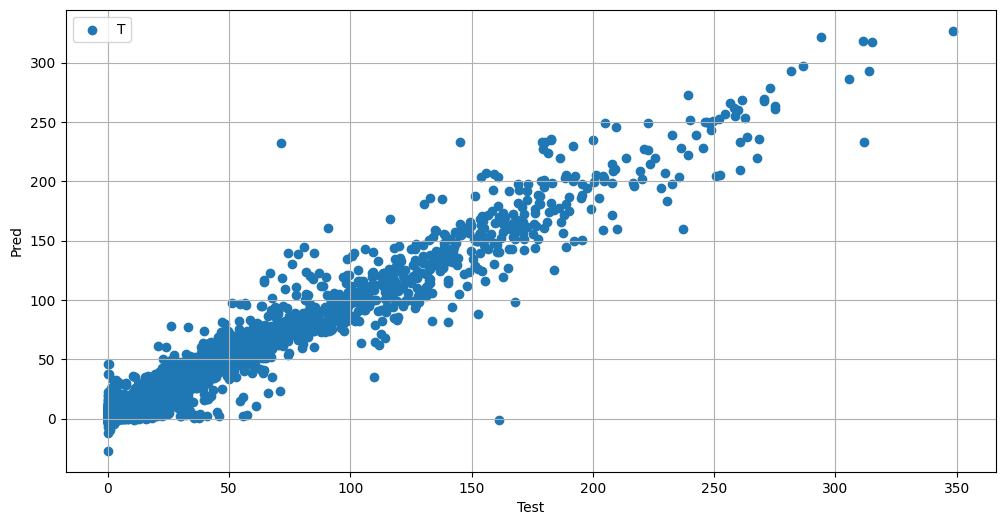

In [ ]:
x_train4, x_val4, y_train4, y_val4 = train_test_split(
    x_ff4_train, y_ff4_train, test_size=0.2, random_state=42)

model_nn4 = Sequential([
    Dense(64, activation='relu', input_shape=(5,)),
    Dense(32, activation='relu'),
    Dense(1)
])

model_nn4.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history_nn4 = model_nn4.fit(x_train4, y_train4, epochs=150,
                            validation_data=(x_val4, y_val4))

# MAE, R2 Score
r2 = r2_score(y_cluster4_test, model_nn4.predict(x_cluster4_test))
mae = mean_absolute_error(y_cluster4_test, model_nn4.predict(x_cluster4_test))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(model_nn4.predict(x_cluster4_test), columns=['Pred'])
y_test_new = y_cluster4_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))


plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

# Download Model (Export)

In [ ]:
joblib.dump(knr, 'Model-KNN.pkl')
joblib.dump(lr, 'Model-KR.pkl')
joblib.dump(model_sgv, 'Model-SVM.pkl')
joblib.dump(model_lstm, 'Model-LSTM.pkl')
joblib.dump(best_rf2, 'Model-RF.pkl')
joblib.dump(best_lgbm, 'Model-LGBM.pkl')
joblib.dump(keras_regressor, 'Model-MLP.pkl')
joblib.dump(best_gbr, 'Model-GBR.pkl')
joblib.dump(elastic_net, 'Model-EN.pkl')
joblib.dump(model_nn1, 'Model-NN.pkl')

['Model-NN.pkl']

# Ensemble Model 1 (RF)

In [ ]:
# 다양한 머신 러닝 모델로부터의 예측 결과를 결합하여 새로운 훈련 데이터셋을 생성

# x_knn = model_knn.predict(x_ff_train)
# x_lstm = model_lstm.predict(x_ff_train)
# x_rf = model_rf.predict(x_ff_train)
# x_nn = model_nn.predict(x_ff_train)
# x_gbr = model_gbr.predict(x_ff_train)
# x_lgbm = model_lgbm.predict(x_ff_train)
# x_mlp = model_mlp.predict(x_ff_train)
# x_svm = model_svm.predict(x_ff_train)

x_knn1 = knn1.predict(x_ff1_train)
x_lstm1 = model_lstm1.predict(x_ff1_train)
x_rf1 = best_rf1.predict(x_ff1_train)
x_nn1 = model_nn1.predict(x_ff1_train)
x_gbr1 = best_gbr1.predict(x_ff1_train)
x_lgbm1 = best_lgbm1.predict(x_ff1_train)
x_mlp1 = model_mlp1.predict(x_ff1_train)
# x_svm1 = model_svm1.predict(x_ff1_train)

df_ens1 = pd.DataFrame(x_knn1, columns=['KNN'])
df_ens1['LSTM'] = x_lstm1
df_ens1['RF'] = x_rf1
df_ens1['NN'] = x_nn1
df_ens1['GBR'] = x_gbr1
df_ens1['LGBM'] = x_lgbm1
df_ens1['MLP'] = x_mlp1
# df_ens1['SVM'] = x_svm
y_ff1_train_new = y_ff1_train.reset_index(drop=True)
df_ens1['value'] = y_ff1_train_new

print(df_ens1.info())
print(df_ens1.head(20))

3640/3640 [==============================] - 8s 2ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s


  77/3640 [..............................] - ETA: 4s

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.8s


3640/3640 [==============================] - 5s 1ms/step
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116470 entries, 0 to 116469
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   KNN     116470 non-null  float64
 1   LSTM    116470 non-null  float32
 2   RF      116470 non-null  float64
 3   NN      116470 non-null  float32
 4   GBR     116470 non-null  float64
 5   LGBM    116470 non-null  float64
 6   MLP     116470 non-null  float64
 7   value   116470 non-null  float64
dtypes: float32(2), float64(6)
memory usage: 6.2 MB
None
        KNN       LSTM         RF         NN        GBR       LGBM        MLP  \
0    9.0538   8.893685   9.949702   7.960717  10.588198  10.341456   8.108252   
1    0.0000   0.155365   0.028780   0.082623   0.028834   0.016484  -0.183278   
2    1.0188   0.939784 

In [ ]:
x_ens1 = df_ens1.drop(['value'], axis=1)
y_ens1 = df_ens1['value']

In [ ]:
scaler1 = StandardScaler()
scaler1.fit(x_ens1)

x_train1 = scaler1.transform(x_ens1)

In [ ]:
model_ens_square1 = RandomForestRegressor(random_state=42, verbose=1)

param_grid = {
    'n_estimators': [200],  # 트리 개수
    'max_depth': [10],  # 트리 최대 깊이
    'min_samples_split': [10],  # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1],  # 최소 샘플 수
    'max_features': ['auto'],  # 분할 시 고려할 특성
    'bootstrap': [True]  # bootstrap(재표본추출) 사용
}

In [ ]:
grid_search_ens1 = GridSearchCV(estimator=model_ens_square1,
                           param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=-1)

grid_search_ens1.fit(x_train1, y_ens1)


best_params_ens1 = grid_search_ens1.best_params_
best_score_ens1 = np.sqrt(-grid_search_ens1.best_score_)  # 음수 MSE를 양수 변환 후 RMSE
print(f"Лучшие параметры: {best_params_ens1}")
print(f"Лучшая RMSE на обучающих данных: {best_score_ens1}")


# 테스트 데이터에 대한 예측
best_ens1 = grid_search_ens1.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   24.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.6min


Лучшие параметры: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Лучшая RMSE на обучающих данных: 1.152984662339195


In [ ]:
df_for_checking1 = pd.DataFrame(knn1.predict(x_cluster1_test), columns=['KNN'])

In [ ]:
df_for_checking1['LSTM'] = model_lstm1.predict(x_cluster1_test)
df_for_checking1['RF'] = best_rf1.predict(x_cluster1_test)
df_for_checking1['NN'] = model_nn1.predict(x_cluster1_test)
df_for_checking1['GBR'] = best_gbr1.predict(x_cluster1_test)
df_for_checking1['LGBM'] = best_lgbm1.predict(x_cluster1_test)
df_for_checking1['MLP'] = model_mlp1.predict(x_cluster1_test)
# df_for_checking1['SVM'] = model_svm1.predict(x_cluster1_test)

910/910 [==============================] - 2s 2ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


 85/910 [=>............................] - ETA: 0s

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


910/910 [==============================] - 1s 1ms/step
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
x_for_checking1 = scaler1.transform(df_for_checking1)

predict_ens1 = best_ens1.predict(x_for_checking1)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


In [ ]:
r2_ensemble1 = r2_score(y_cluster1_test, predict_ens1)
mae_ensemble1 = mean_absolute_error(y_cluster1_test, predict_ens1)

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_ensemble1:.2f}")
print(f"R-squared (R^2): {r2_ensemble1:.2f}")

Mean Absolute Error (MAE): 0.53
R-squared (R^2): 0.93


In [ ]:
# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_ens1, columns=['Pred'])
y_test_new = y_cluster1_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))

         Pred    Test
0    0.123325   0.000
1    0.883905   1.309
2    0.130991   0.294
3    0.973537   0.984
4   13.442223  14.998
5   12.996928  13.902
6    3.693453   3.980
7    3.181334   1.429
8    3.279134   3.838
9    0.001444   0.000
10   0.675631   0.535
11   9.426114  12.110
12   0.616934   0.545
13   0.971057   0.000
14   3.110267   3.190
15   0.616934   0.616
16   0.000355   0.000
17   0.476790   0.448
18   1.426647   1.444
19   2.156282   2.280
20   0.273343   0.000
21   2.743590   0.320
22   0.510726   0.460
23   0.123325   0.000
24   0.581046   0.690
25   0.404327   0.426
26   0.572681   0.600
27   2.623681   3.038
28   0.123325   0.000
29   1.244411   0.000
30   0.619727   0.778
31   0.678711   0.701
32  16.995183  17.540
33   0.003070   0.000
34   6.116173   7.020
35   2.292540   2.357
36   0.202028   0.191
37   0.863296   0.803
38   4.395733   4.391
39   0.000355   0.000
40   0.870626   1.036
41   3.363789   3.548
42   0.000392   0.000
43   0.018138   0.000
44   0.779

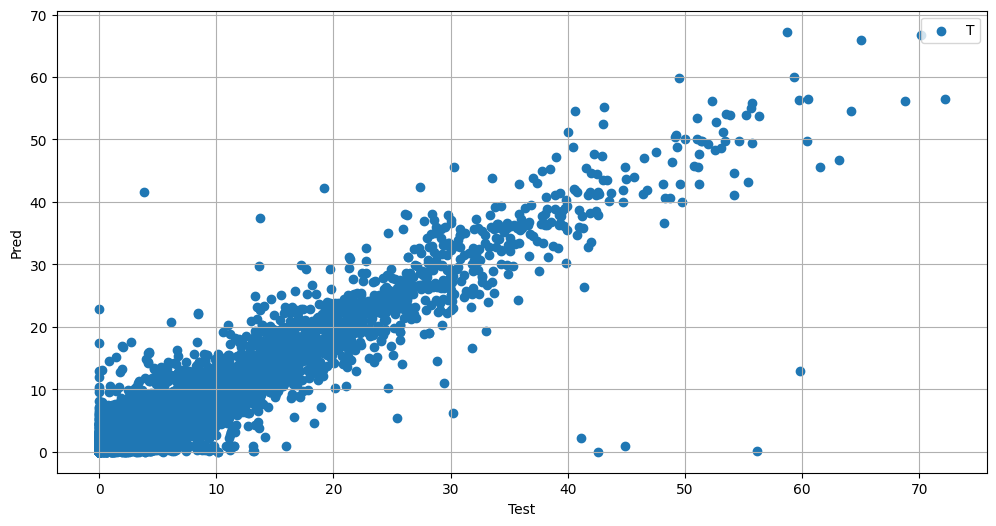

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

2495/2495 [==============================] - 5s 2ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s


   1/2495 [..............................] - ETA: 2:40

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.2s


2495/2495 [==============================] - 7s 3ms/step
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   14.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   59.9s


Лучшие параметры: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Лучшая RMSE на обучающих данных: 0.8403506053008719
624/624 [==============================] - 2s 3ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


 87/624 [===>..........................] - ETA: 0s

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


624/624 [==============================] - 1s 1ms/step
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


Mean Absolute Error (MAE): 0.32
R-squared (R^2): 0.93
         Pred    Test
0    6.678990   6.660
1   11.851732  11.927
2    0.068423   0.000
3    0.009781   0.000
4    5.934105   6.146
5    0.001381   0.000
6    0.977295   0.989
7    1.648267   1.836
8   11.184459  11.640
9    0.005102   0.000
10   1.407174   1.410
11   0.010273   0.000
12   0.396073   0.298
13   0.008986   0.000
14   0.081935   0.047
15   0.536490   2.222
16   0.003464   0.000
17   0.496414   0.457
18   0.004182   0.000
19   5.775649   6.448
20   6.353863   5.567
21   0.004182   0.000
22   0.016249   0.000
23   1.407624   1.396
24   5.769350   5.855
25   0.003722   0.000
26   0.011746   0.000
27   0.043728   0.000
28   7.148771   6.951
29   0.583636   0.661
30   0.354213   0.252
31   5.961985   3.620
32   0.602298   0.776
33   0.631456   0.564
34   0.006448   0.000
35   0.132628   0.130
36   1.424276   1.615
37   3.478715   1.308
38   6.355023   6.289
39   0.010273   0.000
40   0.171128   0.446
41   0.308791   0.048


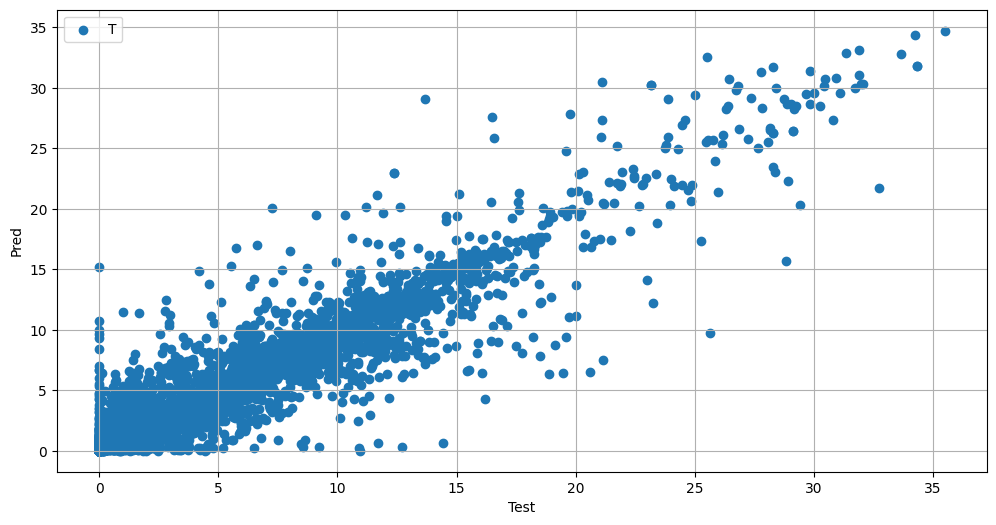

In [ ]:
x_knn3 = knn3.predict(x_ff3_train)
x_lstm3 = model_lstm3.predict(x_ff3_train)
x_rf3 = best_rf3.predict(x_ff3_train)
x_nn3 = model_nn3.predict(x_ff3_train)
x_gbr3 = best_gbr3.predict(x_ff3_train)
x_lgbm3 = best_lgbm3.predict(x_ff3_train)
x_mlp3 = model_mlp3.predict(x_ff3_train)
# x_svm1 = model_svm1.predict(x_ff1_train)

df_ens3 = pd.DataFrame(x_knn3, columns=['KNN'])
df_ens3['LSTM'] = x_lstm3
df_ens3['RF'] = x_rf3
df_ens3['NN'] = x_nn3
df_ens3['GBR'] = x_gbr3
df_ens3['LGBM'] = x_lgbm3
df_ens3['MLP'] = x_mlp3
# df_ens1['SVM'] = x_svm
y_ff3_train_new = y_ff3_train.reset_index(drop=True)
df_ens3['value'] = y_ff3_train_new

x_ens3 = df_ens3.drop(['value'], axis=1)
y_ens3 = df_ens3['value']

scaler3 = StandardScaler()
scaler3.fit(x_ens3)

x_train3 = scaler3.transform(x_ens3)

model_ens_square3 = RandomForestRegressor(random_state=42, verbose=1)

param_grid = {
    'n_estimators': [200],  # 트리 개수
    'max_depth': [10],  # 트리 최대 깊이
    'min_samples_split': [10],  # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1],  # 최소 샘플 수
    'max_features': ['auto'],  # 분할 시 고려할 특성
    'bootstrap': [True]  # bootstrap(재표본추출) 사용
}

grid_search_ens3 = GridSearchCV(estimator=model_ens_square3,
                           param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=-1)

grid_search_ens3.fit(x_train3, y_ens3)


best_params_ens3 = grid_search_ens3.best_params_
best_score_ens3 = np.sqrt(-grid_search_ens3.best_score_)  # 음수 MSE를 양수 변환 후 RMSE
print(f"Лучшие параметры: {best_params_ens3}")
print(f"Лучшая RMSE на обучающих данных: {best_score_ens3}")

# 테스트 데이터에 대한 예측
best_ens3 = grid_search_ens3.best_estimator_

df_for_checking3 = pd.DataFrame(knn3.predict(x_cluster3_test), columns=['KNN'])
df_for_checking3['LSTM'] = model_lstm3.predict(x_cluster3_test)
df_for_checking3['RF'] = best_rf3.predict(x_cluster3_test)
df_for_checking3['NN'] = model_nn3.predict(x_cluster3_test)
df_for_checking3['GBR'] = best_gbr3.predict(x_cluster3_test)
df_for_checking3['LGBM'] = best_lgbm3.predict(x_cluster3_test)
df_for_checking3['MLP'] = model_mlp3.predict(x_cluster3_test)

x_for_checking3 = scaler3.transform(df_for_checking3)

predict_ens3 = best_ens3.predict(x_for_checking3)

r2_ensemble3 = r2_score(y_cluster3_test, predict_ens3)
mae_ensemble3 = mean_absolute_error(y_cluster3_test, predict_ens3)

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_ensemble3:.2f}")
print(f"R-squared (R^2): {r2_ensemble3:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_ens3, columns=['Pred'])
y_test_new = y_cluster3_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))

plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

4020/4020 [==============================] - 9s 2ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s


  77/4020 [..............................] - ETA: 5s

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.8s


4020/4020 [==============================] - 6s 1ms/step
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   24.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.7min


Лучшие параметры: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Лучшая RMSE на обучающих данных: 3.25068233630835
1005/1005 [==============================] - 2s 2ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


  80/1005 [=>............................] - ETA: 1s

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


1005/1005 [==============================] - 1s 1ms/step
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


Mean Absolute Error (MAE): 1.01
R-squared (R^2): 0.96
         Pred    Test
0    0.067672   0.000
1   11.082767   0.000
2    0.003275   0.000
3    0.003275   0.000
4    4.014694   3.709
5    0.613691   0.642
6    2.594403  13.024
7    0.042121   0.000
8    2.839748   3.691
9    0.245228   0.000
10   0.003275   0.000
11   0.819276   0.811
12   0.245228   0.000
13  69.865048  69.000
14   2.088371   1.711
15   0.009279   0.000
16   0.008086   0.000
17  12.633510  17.431
18   8.230344   8.155
19   0.001236   0.000
20   9.674152  13.082
21   0.750612   0.726
22   0.144243   0.157
23  15.102196  16.176
24   0.073283   0.000
25   0.175713   0.000
26  11.572312  15.022
27   0.026768   0.000
28   0.383018   0.000
29   6.660248   6.710
30   6.117667   5.332
31   0.604690   0.570
32   0.029590   0.000
33   0.045641   0.000
34   6.200396   6.356
35   0.003275   0.000
36   6.304885   6.617
37   0.028517   0.001
38  33.312727  34.837
39   0.383018   0.000
40   1.182000   0.895
41   0.026768   0.000


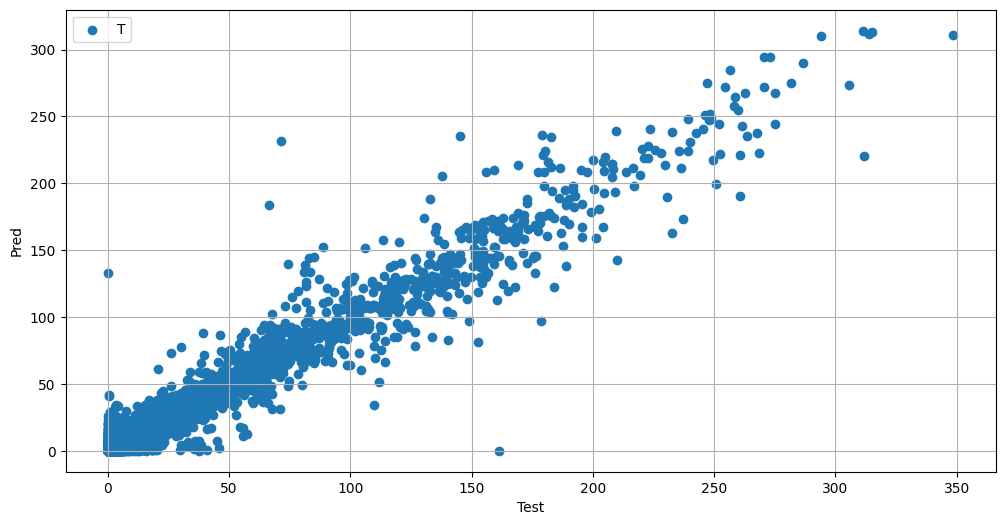

In [ ]:
x_knn4 = knn4.predict(x_ff4_train)
x_lstm4 = model_lstm4.predict(x_ff4_train)
x_rf4 = best_rf4.predict(x_ff4_train)
x_nn4 = model_nn4.predict(x_ff4_train)
x_gbr4 = best_gbr4.predict(x_ff4_train)
x_lgbm4 = best_lgbm4.predict(x_ff4_train)
x_mlp4 = model_mlp4.predict(x_ff4_train)
# x_svm4 = model_svm4.predict(x_ff4_train)

df_ens4 = pd.DataFrame(x_knn4, columns=['KNN'])
df_ens4['LSTM'] = x_lstm4
df_ens4['RF'] = x_rf4
df_ens4['NN'] = x_nn4
df_ens4['GBR'] = x_gbr4
df_ens4['LGBM'] = x_lgbm4
df_ens4['MLP'] = x_mlp4
# df_ens1['SVM'] = x_svm
y_ff4_train_new = y_ff4_train.reset_index(drop=True)
df_ens4['value'] = y_ff4_train_new

x_ens4 = df_ens4.drop(['value'], axis=1)
y_ens4 = df_ens4['value']

scaler4 = StandardScaler()
scaler4.fit(x_ens4)

x_train4 = scaler4.transform(x_ens4)

model_ens_square4 = RandomForestRegressor(random_state=42, verbose=1)

param_grid = {
    'n_estimators': [200],  # 트리 개수
    'max_depth': [10],  # 트리 최대 깊이
    'min_samples_split': [10],  # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1],  # 최소 샘플 수
    'max_features': ['auto'],  # 분할 시 고려할 특성
    'bootstrap': [True]  # bootstrap(재표본추출) 사용
}

grid_search_ens4 = GridSearchCV(estimator=model_ens_square4,
                           param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=-1)

grid_search_ens4.fit(x_train4, y_ens4)


best_params_ens4 = grid_search_ens4.best_params_
best_score_ens4 = np.sqrt(-grid_search_ens4.best_score_)  # 음수 MSE를 양수 변환 후 RMSE
print(f"Лучшие параметры: {best_params_ens4}")
print(f"Лучшая RMSE на обучающих данных: {best_score_ens4}")


# 테스트 데이터에 대한 예측
best_ens4 = grid_search_ens4.best_estimator_

df_for_checking4 = pd.DataFrame(knn4.predict(x_cluster4_test), columns=['KNN'])
df_for_checking4['LSTM'] = model_lstm4.predict(x_cluster4_test)
df_for_checking4['RF'] = best_rf4.predict(x_cluster4_test)
df_for_checking4['NN'] = model_nn4.predict(x_cluster4_test)
df_for_checking4['GBR'] = best_gbr4.predict(x_cluster4_test)
df_for_checking4['LGBM'] = best_lgbm4.predict(x_cluster4_test)
df_for_checking4['MLP'] = model_mlp4.predict(x_cluster4_test)

x_for_checking4 = scaler4.transform(df_for_checking4)

predict_ens4 = best_ens4.predict(x_for_checking4)

r2_ensemble4 = r2_score(y_cluster4_test, predict_ens4)
mae_ensemble4 = mean_absolute_error(y_cluster4_test, predict_ens4)

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_ensemble4:.2f}")
print(f"R-squared (R^2): {r2_ensemble4:.2f}")

# 예측 데이터와 테스트 데이터의 비교
results = pd.DataFrame(predict_ens4, columns=['Pred'])
y_test_new = y_cluster4_test.reset_index(drop=True)
results['Test'] = y_test_new
print(results.head(50))

plt.figure(figsize=(12, 6))
plt.scatter(results['Test'], results['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

# Ensemble Model 2 (NN)

Epoch 1/150
2912/2912 [==============================] - 9s 3ms/step - loss: 1.9155 - mae: 0.5275 - val_loss: 521.6840 - val_mae: 13.0061
Epoch 2/150
2912/2912 [==============================] - 7s 2ms/step - loss: 1.5367 - mae: 0.4773 - val_loss: 844.0746 - val_mae: 15.9653
Epoch 3/150
2912/2912 [==============================] - 7s 3ms/step - loss: 1.4961 - mae: 0.4735 - val_loss: 731.4395 - val_mae: 15.2049
Epoch 4/150
2912/2912 [==============================] - 7s 2ms/step - loss: 1.4783 - mae: 0.4689 - val_loss: 809.6823 - val_mae: 15.5168
Epoch 5/150
2912/2912 [==============================] - 8s 3ms/step - loss: 1.4485 - mae: 0.4652 - val_loss: 768.9569 - val_mae: 15.3151
Epoch 6/150
2912/2912 [==============================] - 7s 2ms/step - loss: 1.4328 - mae: 0.4611 - val_loss: 745.4561 - val_mae: 15.1214
Epoch 7/150
2912/2912 [==============================] - 7s 2ms/step - loss: 1.4308 - mae: 0.4589 - val_loss: 680.1313 - val_mae: 14.0944
Epoch 8/150
2912/2912 [===========

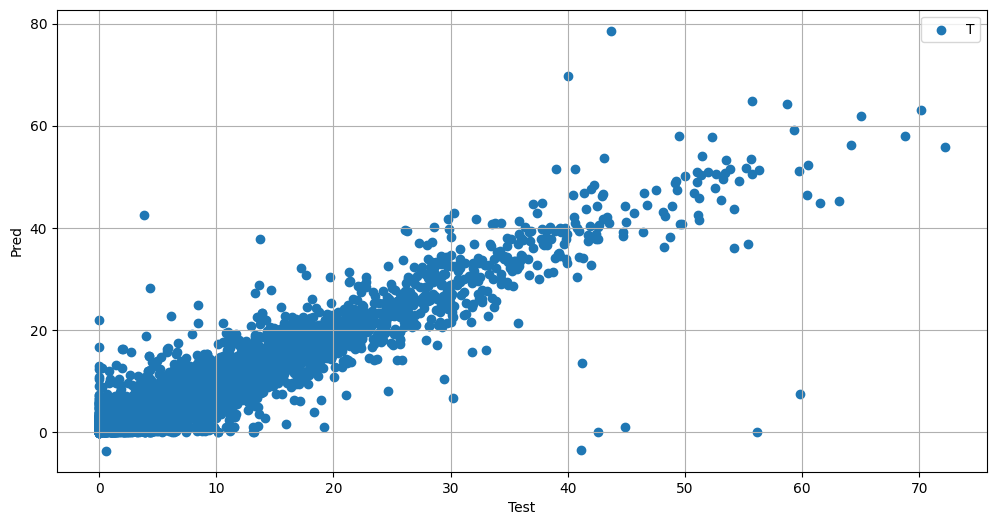

In [ ]:
x_ens2_1 = df_ens1.drop(['value'], axis=1)
y_ens2_1 = df_ens1['value']

x_ens2_1_train, x_ens2_1_val, y_ens2_1_train, y_ens2_1_val = train_test_split(
  x_ens2_1, y_ens2_1, test_size=0.2, random_state=42)

scaler1 = StandardScaler()
scaler1.fit(x_ens2_1)

x_train2_1 = scaler1.transform(x_ens2_1_train)

model_ensemble_nn1 = Sequential([
    Dense(128, activation='relu', input_shape=(7,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model_ensemble_nn1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history_ensemble_nn1 = model_ensemble_nn1.fit(
    x_train2_1, y_ens2_1_train, epochs=150, validation_data=(x_ens2_1_val, y_ens2_1_val))

predict_ensemble2_1 = model_ensemble_nn1.predict(x_for_checking1)

r2_ensemble2_1 = r2_score(y_cluster1_test, predict_ensemble2_1)
mae_ensemble2_1 = mean_absolute_error(y_cluster1_test, predict_ensemble2_1)

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_ensemble2_1:.2f}")
print(f"R-squared (R^2): {r2_ensemble2_1:.2f}")

results_ensemble2_1 = pd.DataFrame(predict_ensemble2_1, columns=['Pred'])
y_test_ensemble2_1 = y_cluster1_test.reset_index(drop=True)
results_ensemble2_1['Test'] = y_test_ensemble2_1
print(results_ensemble2_1.head(50))

plt.figure(figsize=(12, 6))
plt.scatter(results_ensemble2_1['Test'], results_ensemble2_1['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Epoch 1/150
1996/1996 [==============================] - 6s 2ms/step - loss: 1.0117 - mae: 0.3705 - val_loss: 184.2568 - val_mae: 8.3273
Epoch 2/150
1996/1996 [==============================] - 5s 2ms/step - loss: 0.7829 - mae: 0.3333 - val_loss: 156.7005 - val_mae: 7.7327
Epoch 3/150
1996/1996 [==============================] - 6s 3ms/step - loss: 0.7679 - mae: 0.3271 - val_loss: 207.0816 - val_mae: 8.8928
Epoch 4/150
1996/1996 [==============================] - 4s 2ms/step - loss: 0.7585 - mae: 0.3230 - val_loss: 166.3985 - val_mae: 7.9790
Epoch 5/150
1996/1996 [==============================] - 5s 3ms/step - loss: 0.7552 - mae: 0.3224 - val_loss: 179.3241 - val_mae: 8.3294
Epoch 6/150
1996/1996 [==============================] - 5s 2ms/step - loss: 0.7495 - mae: 0.3206 - val_loss: 138.5765 - val_mae: 7.3675
Epoch 7/150
1996/1996 [==============================] - 4s 2ms/step - loss: 0.7550 - mae: 0.3186 - val_loss: 195.6792 - val_mae: 8.6244
Epoch 8/150
1996/1996 [==================

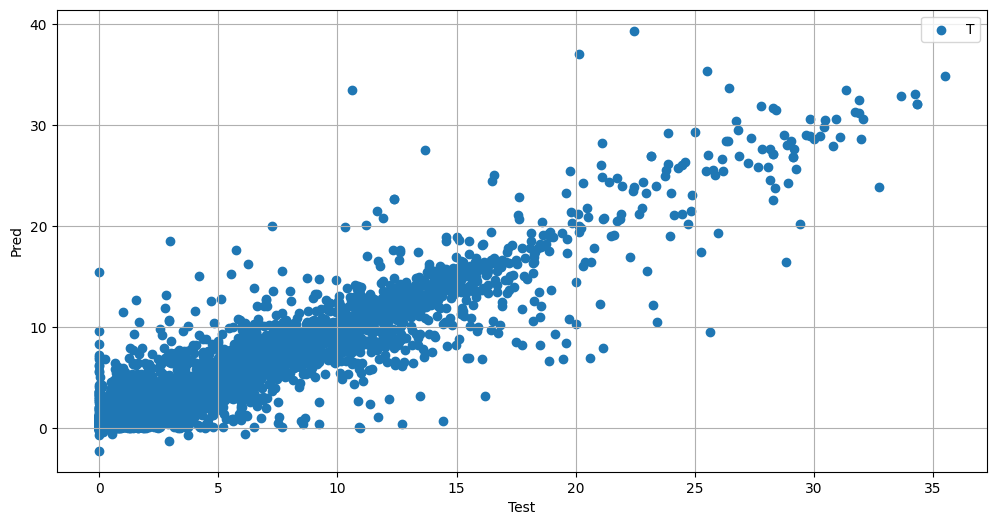

In [ ]:
x_ens2_3 = df_ens3.drop(['value'], axis=1)
y_ens2_3 = df_ens3['value']

x_ens2_3_train, x_ens2_3_val, y_ens2_3_train, y_ens2_3_val = train_test_split(
  x_ens2_3, y_ens2_3, test_size=0.2, random_state=42)

scaler3 = StandardScaler()
scaler3.fit(x_ens3)

x_train2_3 = scaler3.transform(x_ens2_3_train)

model_ensemble_nn3 = Sequential([
    Dense(128, activation='relu', input_shape=(7,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model_ensemble_nn3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history_ensemble_nn3 = model_ensemble_nn3.fit(
    x_train2_3, y_ens2_3_train, epochs=150, validation_data=(x_ens2_3_val, y_ens2_3_val))

predict_ensemble2_3 = model_ensemble_nn3.predict(x_for_checking3)

r2_ensemble2_3 = r2_score(y_cluster3_test, predict_ensemble2_3)
mae_ensemble2_3 = mean_absolute_error(y_cluster3_test, predict_ensemble2_3)

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_ensemble2_3:.2f}")
print(f"R-squared (R^2): {r2_ensemble2_3:.2f}")

results_ensemble2_3 = pd.DataFrame(predict_ensemble2_3, columns=['Pred'])
y_test_ensemble2_3 = y_cluster3_test.reset_index(drop=True)
results_ensemble2_3['Test'] = y_test_ensemble2_3
print(results_ensemble2_3.head(50))

plt.figure(figsize=(12, 6))
plt.scatter(results_ensemble2_3['Test'], results_ensemble2_3['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

Epoch 1/150
3216/3216 [==============================] - 9s 3ms/step - loss: 23.7692 - mae: 1.1679 - val_loss: 217112.1875 - val_mae: 143.9570
Epoch 2/150
3216/3216 [==============================] - 8s 3ms/step - loss: 13.3022 - mae: 1.0334 - val_loss: 202127.6250 - val_mae: 139.3173
Epoch 3/150
3216/3216 [==============================] - 12s 4ms/step - loss: 12.5290 - mae: 1.0098 - val_loss: 221926.2031 - val_mae: 146.1666
Epoch 4/150
3216/3216 [==============================] - 7s 2ms/step - loss: 12.1823 - mae: 0.9851 - val_loss: 183661.7656 - val_mae: 132.6641
Epoch 5/150
3216/3216 [==============================] - 8s 3ms/step - loss: 12.2960 - mae: 0.9948 - val_loss: 195847.3906 - val_mae: 136.8056
Epoch 6/150
3216/3216 [==============================] - 7s 2ms/step - loss: 12.0022 - mae: 0.9793 - val_loss: 220805.4844 - val_mae: 145.1672
Epoch 7/150
3216/3216 [==============================] - 8s 2ms/step - loss: 11.9954 - mae: 0.9792 - val_loss: 229031.0312 - val_mae: 147.887

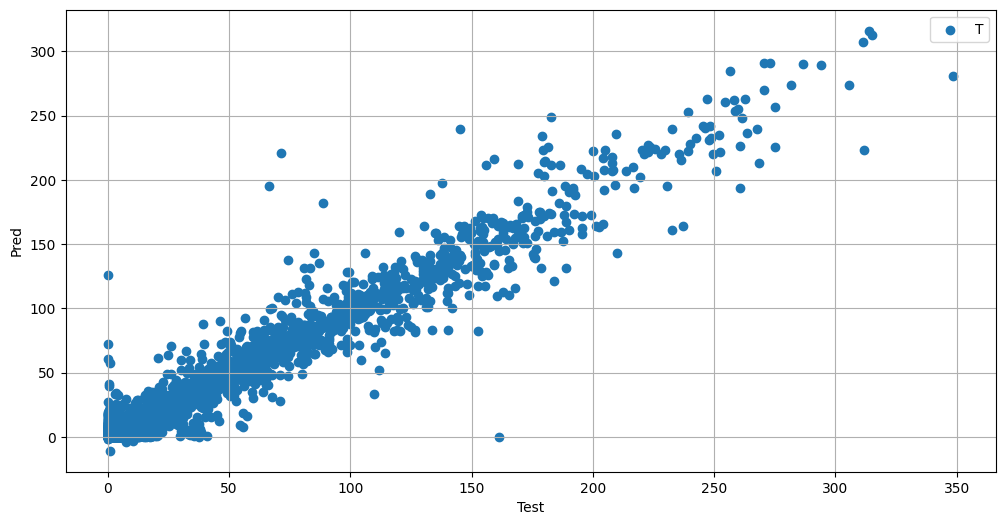

In [ ]:
x_ens2_4 = df_ens4.drop(['value'], axis=1)
y_ens2_4 = df_ens4['value']

x_ens2_4_train, x_ens2_4_val, y_ens2_4_train, y_ens2_4_val = train_test_split(
  x_ens2_4, y_ens2_4, test_size=0.2, random_state=42)

scaler4 = StandardScaler()
scaler4.fit(x_ens4)

x_train2_4 = scaler4.transform(x_ens2_4_train)

model_ensemble_nn4 = Sequential([
    Dense(128, activation='relu', input_shape=(7,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model_ensemble_nn4.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history_ensemble_nn4 = model_ensemble_nn4.fit(
    x_train2_4, y_ens2_4_train, epochs=150, validation_data=(x_ens2_4_val, y_ens2_4_val))

predict_ensemble2_4 = model_ensemble_nn4.predict(x_for_checking4)

r2_ensemble2_4 = r2_score(y_cluster4_test, predict_ensemble2_4)
mae_ensemble2_4 = mean_absolute_error(y_cluster4_test, predict_ensemble2_4)

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_ensemble2_4:.2f}")
print(f"R-squared (R^2): {r2_ensemble2_4:.2f}")

results_ensemble2_4 = pd.DataFrame(predict_ensemble2_4, columns=['Pred'])
y_test_ensemble2_4 = y_cluster4_test.reset_index(drop=True)
results_ensemble2_4['Test'] = y_test_ensemble2_4
print(results_ensemble2_4.head(50))

plt.figure(figsize=(12, 6))
plt.scatter(results_ensemble2_4['Test'], results_ensemble2_4['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

# Ensemble Model 3 (Voting)

In [ ]:
ensemble_voting1 = VotingRegressor(estimators=[
    ('RF', best_rf1),
    ('MLP', model_mlp1),
    ('KNN', knn1),
    ('GBR', best_gbr1),
    ('LGBM', best_lgbm1),
])

ensemble_voting4 = VotingRegressor(estimators=[
    ('RF', best_rf4),
    ('MLP', model_mlp4),
    ('KNN', knn2),
    ('GBR', best_gbr4),
    ('LGBM', best_lgbm4),
])

ensemble_voting3 = VotingRegressor(estimators=[
    ('RF', best_rf3),
    ('MLP', model_mlp3),
    ('KNN', knn3),
    ('GBR', best_gbr3),
    ('LGBM', best_lgbm3),
])

In [ ]:
scaler1 = StandardScaler()
scaler4 = StandardScaler()
scaler3 = StandardScaler()

scaler1.fit(x_ff1_train)
scaler4.fit(x_ff4_train)
scaler3.fit(x_ff3_train)

x_ff1_train = scaler1.transform(x_ff1_train)
x_ff4_train = scaler4.transform(x_ff4_train)
x_ff3_train = scaler3.transform(x_ff3_train)

ensemble_voting1.fit(x_ff1_train, y_ff1_train)
ensemble_voting4.fit(x_ff4_train, y_ff4_train)
ensemble_voting3.fit(x_ff3_train, y_ff3_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   51.1s


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 116470, number of used features: 5
[LightGBM] [Info] Start training from score 2.826267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   13.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   52.3s


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 128632, number of used features: 5
[LightGBM] [Info] Start training from score 6.541921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   31.6s


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 79822, number of used features: 5
[LightGBM] [Info] Start training from score 2.186415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

VotingRegressor(estimators=[('RF',
                             RandomForestRegressor(max_depth=10,
                                                   max_features='auto',
                                                   min_samples_split=10,
                                                   n_estimators=200,
                                                   random_state=42,
                                                   verbose=1)),
                            ('MLP',
                             MLPRegressor(hidden_layer_sizes=(64, 32),
                                          learning_rate='adaptive',
                                          max_iter=1000)),
                            ('KNN', KNeighborsRegressor(n_neighbors=13)),
                            ('GBR',
                             GradientBoostingRegressor(learning_rate=0.2,
                                                       max_depth=5,
                                                       n_estimators=50,
                                                       random_state=42)),
                            ('LGBM',
                             LGBMRegressor(max_depth=5, n_estimators=200,
                                           random_state=42))])

In [ ]:
predict_voting1 = ensemble_voting1.predict(x_cluster1_test)
predict_voting4 = ensemble_voting4.predict(x_cluster4_test)
predict_voting3 = ensemble_voting3.predict(x_cluster3_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
r2_voting1 = r2_score(y_cluster1_test, predict_voting1)
mae_voting1 = mean_absolute_error(y_cluster1_test, predict_voting1)

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_voting1:.2f}")
print(f"R-squared (R^2): {r2_voting1:.2f}")

r2_voting4 = r2_score(y_cluster4_test, predict_voting4)
mae_voting4 = mean_absolute_error(y_cluster4_test, predict_voting4)

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_voting4:.2f}")
print(f"R-squared (R^2): {r2_voting4:.2f}")

r2_voting3 = r2_score(y_cluster3_test, predict_voting3)
mae_voting3 = mean_absolute_error(y_cluster3_test, predict_voting3)

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_voting3:.2f}")
print(f"R-squared (R^2): {r2_voting3:.2f}")

Mean Absolute Error (MAE): 0.53
R-squared (R^2): 0.93
Mean Absolute Error (MAE): 1.05
R-squared (R^2): 0.97
Mean Absolute Error (MAE): 0.32
R-squared (R^2): 0.94


         Pred    Test
0    0.036971   0.000
1    1.547764   1.309
2    0.316997   0.294
3    0.995096   0.984
4   13.091405  14.998
5   14.214744  13.902
6    2.876954   3.980
7    3.212547   1.429
8    3.406809   3.838
9    0.031553   0.000
10   0.768695   0.535
11   5.165534  12.110
12   0.724362   0.545
13   0.891468   0.000
14   3.091057   3.190
15   0.615019   0.616
16  -0.021257   0.000
17   0.608559   0.448
18   1.382470   1.444
19   1.877828   2.280
20   0.256312   0.000
21   2.619243   0.320
22   0.484185   0.460
23   0.036971   0.000
24   0.615436   0.690
25   0.475412   0.426
26   0.508931   0.600
27   1.831518   3.038
28   0.036971   0.000
29   0.893632   0.000
30   0.719100   0.778
31   0.798175   0.701
32  17.248643  17.540
33  -0.020044   0.000
34   6.257280   7.020
35   2.316844   2.357
36   0.125993   0.191
37   0.874224   0.803
38   4.385927   4.391
39  -0.029994   0.000
40   0.790584   1.036
41   3.364902   3.548
42  -0.014819   0.000
43  -0.016488   0.000
44   0.862

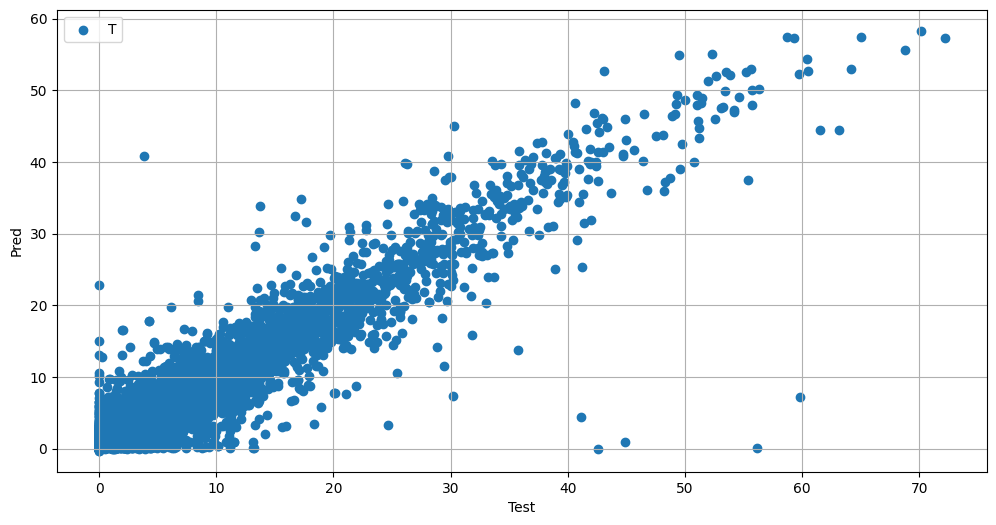

In [ ]:
results_voting = pd.DataFrame(predict_voting1, columns=['Pred'])
y_test_new = y_cluster1_test.reset_index(drop=True)
results_voting['Test'] = y_test_new
print(results_voting.head(50))

plt.figure(figsize=(12, 6))
plt.scatter(results_voting['Test'], results_voting['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

         Pred    Test
0    0.248859   0.000
1   11.148670   0.000
2    0.132494   0.000
3    0.132494   0.000
4    3.470729   3.709
5    0.677928   0.642
6    2.867302  13.024
7    0.037747   0.000
8    3.558521   3.691
9    0.221328   0.000
10   0.132494   0.000
11   0.885810   0.811
12   0.221328   0.000
13  68.539483  69.000
14   3.270611   1.711
15   0.055694   0.000
16   0.087294   0.000
17  13.278881  17.431
18   8.238610   8.155
19  -0.020657   0.000
20  11.448514  13.082
21   0.785018   0.726
22   0.561826   0.157
23  15.715468  16.176
24   0.230753   0.000
25   0.230846   0.000
26   9.884508  15.022
27   0.115603   0.000
28   0.803557   0.000
29   6.292119   6.710
30   6.039102   5.332
31   0.691671   0.570
32   0.117066   0.000
33   0.092317   0.000
34   6.296780   6.356
35   0.132494   0.000
36   5.377610   6.617
37   0.690571   0.001
38  32.871228  34.837
39   0.803557   0.000
40   1.191982   0.895
41   0.115603   0.000
42   0.098581   0.000
43   2.035279   2.707
44   0.225

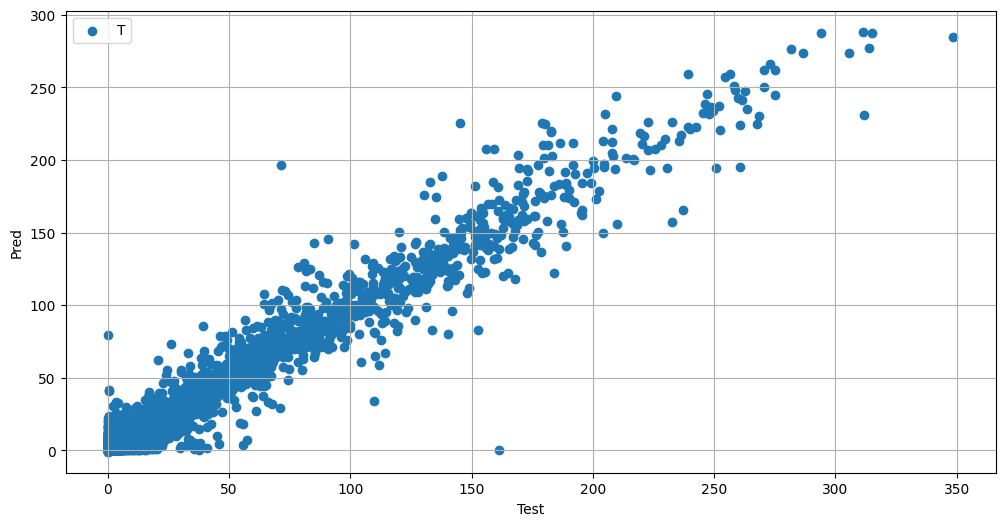

In [ ]:
results_voting = pd.DataFrame(predict_voting4, columns=['Pred'])
y_test_new = y_cluster4_test.reset_index(drop=True)
results_voting['Test'] = y_test_new
print(results_voting.head(50))

plt.figure(figsize=(12, 6))
plt.scatter(results_voting['Test'], results_voting['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

         Pred    Test
0    6.741650   6.660
1   11.564656  11.927
2    0.029617   0.000
3   -0.004841   0.000
4    6.034816   6.146
5   -0.007437   0.000
6    0.847291   0.989
7    1.265854   1.836
8    9.847828  11.640
9   -0.008078   0.000
10   1.370144   1.410
11  -0.009069   0.000
12   0.498734   0.298
13   0.028720   0.000
14   0.066315   0.047
15   1.118425   2.222
16  -0.019690   0.000
17   0.508849   0.457
18  -0.005224   0.000
19   5.689336   6.448
20   6.465925   5.567
21  -0.005224   0.000
22   0.019213   0.000
23   1.349251   1.396
24   5.831763   5.855
25   0.005013   0.000
26  -0.003056   0.000
27   0.080809   0.000
28   7.723975   6.951
29   0.650900   0.661
30   0.378193   0.252
31   6.055874   3.620
32   0.645147   0.776
33   0.536351   0.564
34  -0.010024   0.000
35   0.106971   0.130
36   1.412376   1.615
37   3.124949   1.308
38   6.413420   6.289
39  -0.009069   0.000
40   0.145339   0.446
41   0.547996   0.048
42   0.017807   0.046
43   0.745493   0.785
44   6.611

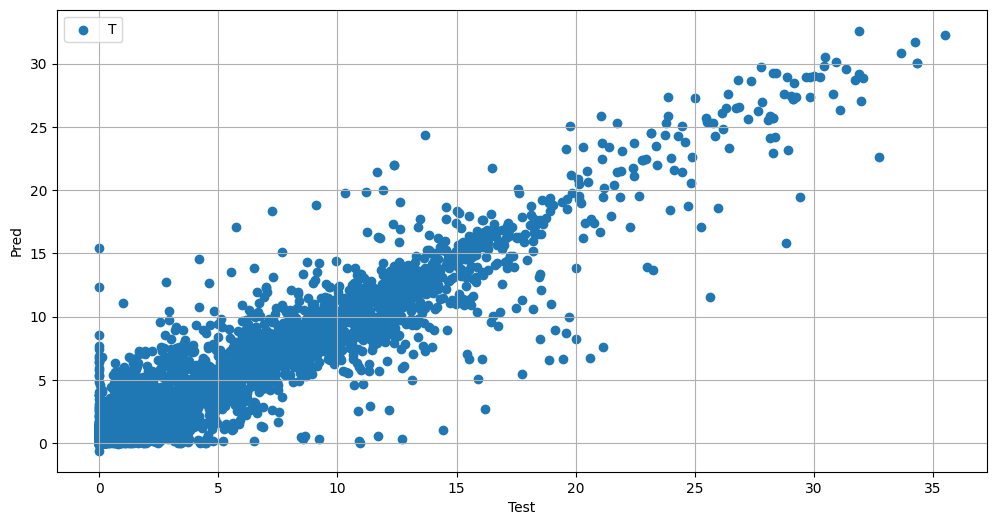

In [ ]:
results_voting = pd.DataFrame(predict_voting3, columns=['Pred'])
y_test_new = y_cluster3_test.reset_index(drop=True)
results_voting['Test'] = y_test_new
print(results_voting.head(50))

plt.figure(figsize=(12, 6))
plt.scatter(results_voting['Test'], results_voting['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

# Ensemble Model (Stacking)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
3640/3640 [==============================] - 6s 2ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.8s


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
910/910 [==============================] - 2s 2ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s


Mean Absolute Error (MAE): 0.55
R-squared (R^2): 0.92
Mean Absolute Error (MAE): 0.51
R-squared (R^2): 0.93
         Pred    Test
0    0.044111   0.000
1    0.978959   1.309
2    0.242833   0.294
3    0.925133   0.984
4   13.156877  14.998
5   13.055721  13.902
6    2.798091   3.980
7    3.412321   1.429
8    3.315150   3.838
9   -0.046340   0.000
10   0.511624   0.535
11   6.646967  12.110
12   0.594489   0.545
13   0.812106   0.000
14   3.096583   3.190
15   0.671963   0.616
16  -0.014887   0.000
17   0.668497   0.448
18   1.407714   1.444
19   2.204937   2.280
20   0.266453   0.000
21   2.586531   0.320
22   0.510166   0.460
23   0.044111   0.000
24   0.640178   0.690
25   0.497886   0.426
26   0.480198   0.600
27   2.333834   3.038
28   0.044111   0.000
29   0.969135   0.000
30   0.759750   0.778
31   0.879309   0.701
32  17.786615  17.540
33   0.005389   0.000
34   6.243794   7.020
35   2.643771   2.357
36   0.031750   0.191
37   0.823820   0.803
38   4.134133   4.391
39   0.00068

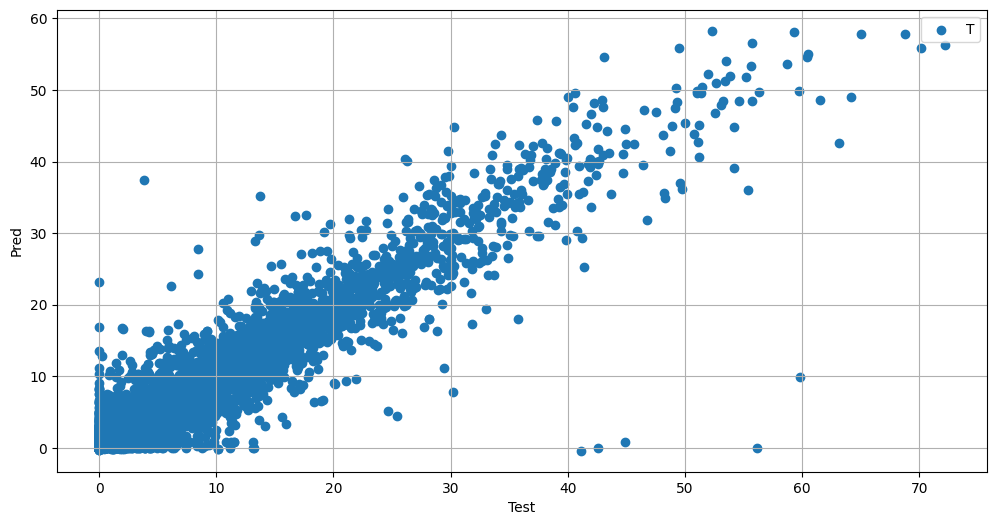

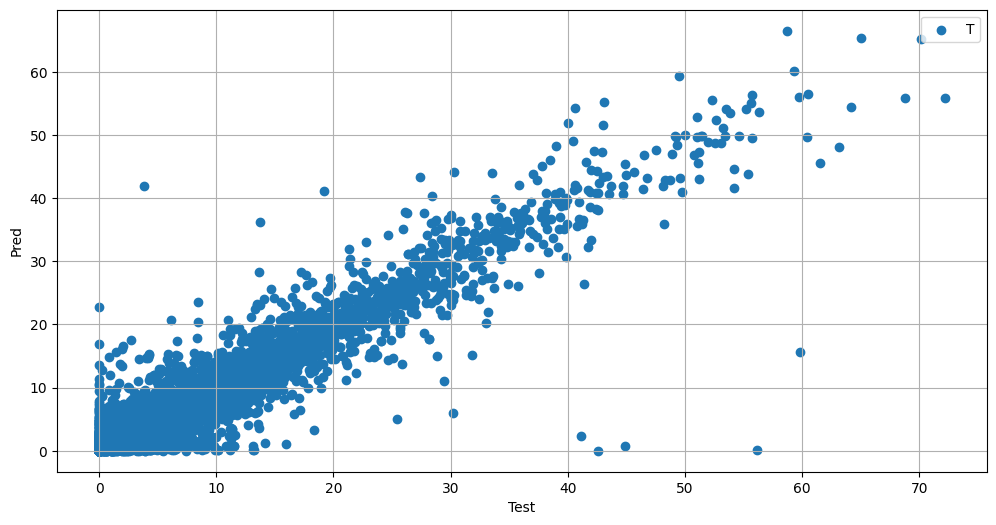

In [ ]:
meta_x_train1 = np.column_stack((
    knn1.predict(x_ff1_train),
    best_gbr1.predict(x_ff1_train),
    best_lgbm1.predict(x_ff1_train),
    model_lstm1.predict(x_ff1_train),
    model_mlp1.predict(x_ff1_train),
    model_nn1.predict(x_ff1_train),
    best_rf1.predict(x_ff1_train)))

meta_x_test1 = np.column_stack((
    knn1.predict(x_cluster1_test),
    best_gbr1.predict(x_cluster1_test),
    best_lgbm1.predict(x_cluster1_test),
    model_lstm1.predict(x_cluster1_test),
    model_mlp1.predict(x_cluster1_test),
    model_nn1.predict(x_cluster1_test),
    best_rf1.predict(x_cluster1_test)))

meta_model1_1 = LinearRegression()
meta_model1_1.fit(meta_x_train1, y_ff1_train)

meta_model2_1 = RandomForestRegressor(random_state=42, verbose=1)
meta_model2_1.fit(meta_x_train1, y_ff1_train)

stacked_predictions1_1 = meta_model1_1.predict(meta_x_test1)
stacked_predictions2_1 = meta_model2_1.predict(meta_x_test1)

r2_stacked1_1 = r2_score(y_cluster1_test, stacked_predictions1_1)
mae_stacked1_1 = mean_absolute_error(y_cluster1_test, stacked_predictions1_1)

r2_stacked2_1 = r2_score(y_cluster1_test, stacked_predictions2_1)
mae_stacked2_1 = mean_absolute_error(y_cluster1_test, stacked_predictions2_1)

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_stacked1_1:.2f}")
print(f"R-squared (R^2): {r2_stacked1_1:.2f}")

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_stacked2_1:.2f}")
print(f"R-squared (R^2): {r2_stacked2_1:.2f}")

results_stacked1_1 = pd.DataFrame(stacked_predictions1_1, columns=['Pred'])
y_test_new = y_cluster1_test.reset_index(drop=True)
results_stacked1_1['Test'] = y_test_new
print(results_stacked1_1.head(50))

results_stacked2_1 = pd.DataFrame(stacked_predictions2_1, columns=['Pred'])
y_test_new = y_cluster1_test.reset_index(drop=True)
results_stacked2_1['Test'] = y_test_new
print(results_stacked2_1.head(50))

plt.figure(figsize=(12, 6))
plt.scatter(results_stacked1_1['Test'], results_stacked1_1['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(results_stacked2_1['Test'], results_stacked2_1['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
2495/2495 [==============================] - 4s 1ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.2s


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
624/624 [==============================] - 1s 1ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   33.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


Mean Absolute Error (MAE): 0.34
R-squared (R^2): 0.94
Mean Absolute Error (MAE): 0.33
R-squared (R^2): 0.93
         Pred    Test
0    6.832401   6.660
1   12.153378  11.927
2    0.068852   0.000
3   -0.004376   0.000
4    6.163996   6.146
5   -0.039992   0.000
6    0.911831   0.989
7    1.089353   1.836
8   10.770414  11.640
9   -0.021642   0.000
10   1.417272   1.410
11  -0.014477   0.000
12   0.503911   0.298
13  -0.000839   0.000
14   0.035720   0.047
15   1.133954   2.222
16  -0.000857   0.000
17   0.710280   0.457
18  -0.036078   0.000
19   5.970534   6.448
20   6.294020   5.567
21  -0.036078   0.000
22   0.037710   0.000
23   1.402301   1.396
24   5.930320   5.855
25   0.002154   0.000
26  -0.027799   0.000
27   0.065158   0.000
28   7.623727   6.951
29   0.715732   0.661
30   0.298635   0.252
31   6.281425   3.620
32   0.670873   0.776
33   0.565213   0.564
34  -0.007646   0.000
35   0.121951   0.130
36   1.643030   1.615
37   3.451337   1.308
38   6.416808   6.289
39  -0.01447

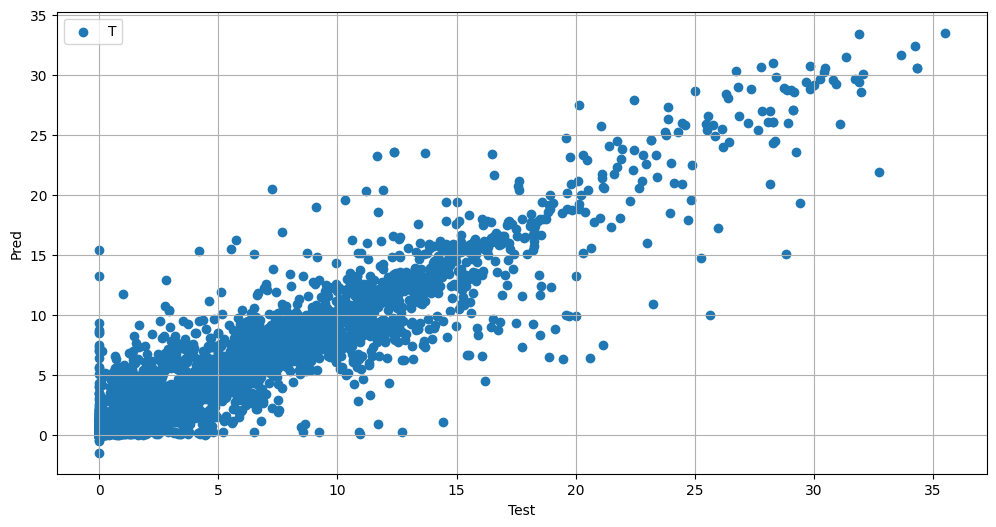

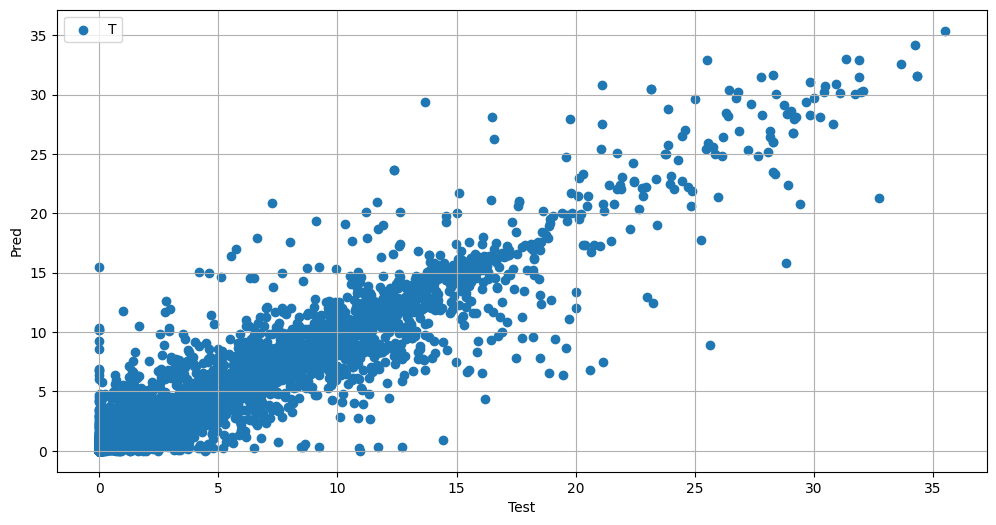

In [ ]:
meta_x_train3 = np.column_stack((
    knn3.predict(x_ff3_train),
    best_gbr3.predict(x_ff3_train),
    best_lgbm3.predict(x_ff3_train),
    model_lstm3.predict(x_ff3_train),
    model_mlp3.predict(x_ff3_train),
    model_nn3.predict(x_ff3_train),
    best_rf3.predict(x_ff3_train)))

meta_x_test3 = np.column_stack((
    knn3.predict(x_cluster3_test),
    best_gbr3.predict(x_cluster3_test),
    best_lgbm3.predict(x_cluster3_test),
    model_lstm3.predict(x_cluster3_test),
    model_mlp3.predict(x_cluster3_test),
    model_nn3.predict(x_cluster3_test),
    best_rf3.predict(x_cluster3_test)))

meta_model1_3 = LinearRegression()
meta_model1_3.fit(meta_x_train3, y_ff3_train)

meta_model2_3 = RandomForestRegressor(random_state=42, verbose=1)
meta_model2_3.fit(meta_x_train3, y_ff3_train)

stacked_predictions1_3 = meta_model1_3.predict(meta_x_test3)
stacked_predictions2_3 = meta_model2_3.predict(meta_x_test3)

r2_stacked1_3 = r2_score(y_cluster3_test, stacked_predictions1_3)
mae_stacked1_3 = mean_absolute_error(y_cluster3_test, stacked_predictions1_3)

r2_stacked2_3 = r2_score(y_cluster3_test, stacked_predictions2_3)
mae_stacked2_3 = mean_absolute_error(y_cluster3_test, stacked_predictions2_3)

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_stacked1_3:.2f}")
print(f"R-squared (R^2): {r2_stacked1_3:.2f}")

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_stacked2_3:.2f}")
print(f"R-squared (R^2): {r2_stacked2_3:.2f}")

results_stacked1_3 = pd.DataFrame(stacked_predictions1_3, columns=['Pred'])
y_test_new = y_cluster3_test.reset_index(drop=True)
results_stacked1_3['Test'] = y_test_new
print(results_stacked1_3.head(50))

results_stacked2_3 = pd.DataFrame(stacked_predictions2_3, columns=['Pred'])
y_test_new = y_cluster3_test.reset_index(drop=True)
results_stacked2_3['Test'] = y_test_new
print(results_stacked2_3.head(50))

plt.figure(figsize=(12, 6))
plt.scatter(results_stacked1_3['Test'], results_stacked1_3['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(results_stacked2_3['Test'], results_stacked2_3['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
4020/4020 [==============================] - 6s 2ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.8s


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
1005/1005 [==============================] - 1s 1ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s


Mean Absolute Error (MAE): 1.12
R-squared (R^2): 0.96
Mean Absolute Error (MAE): 1.02
R-squared (R^2): 0.96
         Pred    Test
0   -0.004408   0.000
1   10.114038   0.000
2   -0.146690   0.000
3   -0.146690   0.000
4    3.272996   3.709
5    0.486979   0.642
6    2.987782  13.024
7    0.046847   0.000
8    3.281952   3.691
9    0.110378   0.000
10  -0.146690   0.000
11   1.056425   0.811
12   0.110378   0.000
13  69.249337  69.000
14   1.229046   1.711
15  -0.196776   0.000
16  -0.151346   0.000
17   9.473226  17.431
18   8.644333   8.155
19   0.021517   0.000
20  11.804726  13.082
21   1.015008   0.726
22   0.935210   0.157
23  15.702017  16.176
24   0.000217   0.000
25  -0.032245   0.000
26  11.760322  15.022
27  -0.088191   0.000
28   0.174853   0.000
29   5.943340   6.710
30   5.866496   5.332
31   0.435952   0.570
32  -0.122834   0.000
33   0.049915   0.000
34   6.453738   6.356
35  -0.146690   0.000
36   4.079166   6.617
37  -0.218181   0.001
38  32.187577  34.837
39   0.17485

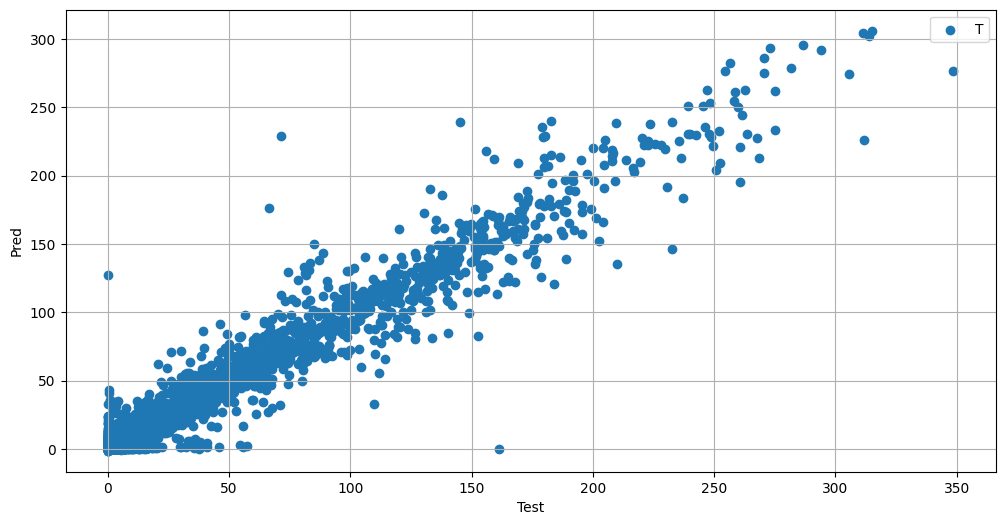

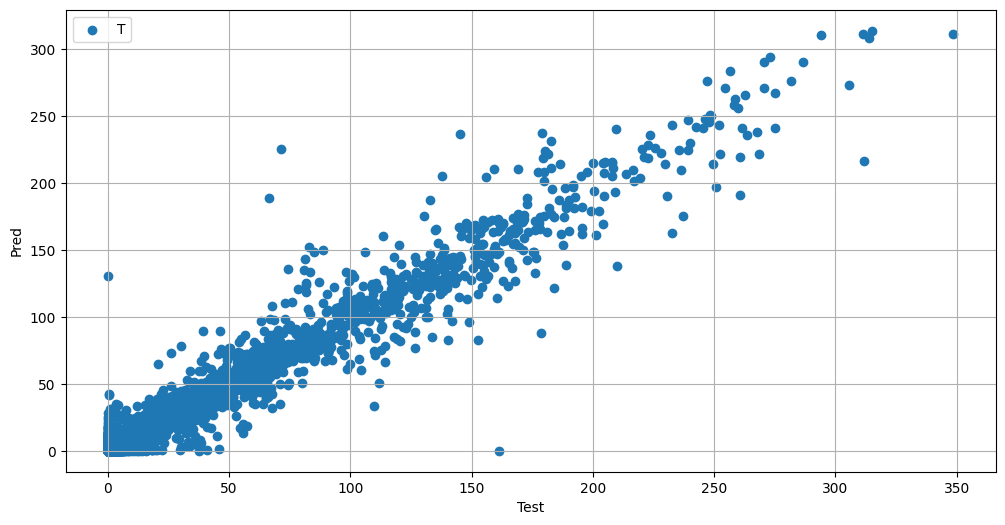

In [ ]:
meta_x_train4 = np.column_stack((
    knn4.predict(x_ff4_train),
    best_gbr4.predict(x_ff4_train),
    best_lgbm4.predict(x_ff4_train),
    model_lstm4.predict(x_ff4_train),
    model_mlp4.predict(x_ff4_train),
    model_nn4.predict(x_ff4_train),
    best_rf4.predict(x_ff4_train)))

meta_x_test4 = np.column_stack((
    knn4.predict(x_cluster4_test),
    best_gbr4.predict(x_cluster4_test),
    best_lgbm4.predict(x_cluster4_test),
    model_lstm4.predict(x_cluster4_test),
    model_mlp4.predict(x_cluster4_test),
    model_nn4.predict(x_cluster4_test),
    best_rf4.predict(x_cluster4_test)))

meta_model1_4 = LinearRegression()
meta_model1_4.fit(meta_x_train4, y_ff4_train)

meta_model2_4 = RandomForestRegressor(random_state=42, verbose=1)
meta_model2_4.fit(meta_x_train4, y_ff4_train)

stacked_predictions1_4 = meta_model1_4.predict(meta_x_test4)
stacked_predictions2_4 = meta_model2_4.predict(meta_x_test4)

r2_stacked1_4 = r2_score(y_cluster4_test, stacked_predictions1_4)
mae_stacked1_4 = mean_absolute_error(y_cluster4_test, stacked_predictions1_4)

r2_stacked2_4 = r2_score(y_cluster4_test, stacked_predictions2_4)
mae_stacked2_4 = mean_absolute_error(y_cluster4_test, stacked_predictions2_4)

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_stacked1_4:.2f}")
print(f"R-squared (R^2): {r2_stacked1_4:.2f}")

# MAE, R2 Score
print(f"Mean Absolute Error (MAE): {mae_stacked2_4:.2f}")
print(f"R-squared (R^2): {r2_stacked2_4:.2f}")

results_stacked1_4 = pd.DataFrame(stacked_predictions1_4, columns=['Pred'])
y_test_new = y_cluster4_test.reset_index(drop=True)
results_stacked1_4['Test'] = y_test_new
print(results_stacked1_4.head(50))

results_stacked2_4 = pd.DataFrame(stacked_predictions2_4, columns=['Pred'])
y_test_new = y_cluster4_test.reset_index(drop=True)
results_stacked2_4['Test'] = y_test_new
print(results_stacked2_4.head(50))

plt.figure(figsize=(12, 6))
plt.scatter(results_stacked1_4['Test'], results_stacked1_4['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(results_stacked2_4['Test'], results_stacked2_4['Pred'], label='Value')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.legend('Test vs Pred')
plt.grid(True)
plt.show()